In [32]:
import pandas as pd
import pyarrow.feather as feather
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import requests
from sklearn.manifold import TSNE

from src.load_data import *
from src.graph_data import *
from src.utils import *
from src.scripts import *

In [18]:
# new import list (add all needed imports here not)
import os
import pyarrow.feather as feather
from src.scripts.load_data import load_data
from src.scripts.convert_into_df import paths_to_df, articles_to_df
from src.scripts.path_processing import filter_paths
from src.scripts.backup_dfs import backup_dataframes
from src.utils.helpers import plot_path_length_distributions, plot_by_distance, plot_duration_histogram, plot_styled_bar_chart

In [3]:
#%pip install -r requirements.txt

# Part 0 : Data Handling 

## Load and Convert Data into Dataframes
 Here, we rearange the data making it easier to work with. It is splitt in two data frames described as follows :  


## Article DF
| Article | Category |linkTargets | distances | plain_text | 
| ------- | ---------- | ------------ | ---------- | ---------- |
| string | list[string] | list[string] | dict[string, int] | string | 

**Column Explanations**  
`Article`: The article title  
`Category`: list of the categories the article belongs to  
`linkTargets`: list of the outgoing links, i.e the direct article titles  
`distances`: the distances of the article to all other articles in the network    
`plain_text`: full article in plain text

## Path DF
| hashedIpAddress | timestamp   | durationInSec | path         | finished | identifier | full_path    | simplified_path | distance |full_path_length | simplified_path_length | distance |  
|------------------|------------|---------------|--------------|----------|------------|--------------|----------|-----------------|------------------|-----------------------|----------|  
| string           | int        | int           |     string   | bool     | string     | list[string] | list[string]  |  int   | int              | int                   | int      |  



**Column Explanations**  
`hashedIpAdress`: identifies the computer from wich the game was played. We assume same IpAdress => same player.  
`timestamp`: game time stamp  
`durationInSec`: the time in seconds it took to play the path  
`identifier`: identifier for games that have the same start and target article pair  
`full_path`: path with all visited articles  
`simplified_path`: direct path excluding detour articles  
`distance`: the shortest possible distance from start to target article  
`full_path_length`: number of clicks in full path, so the length of the full path - 1  
`simplified_path_length`: number of clikcs in direct path, so the langth of the simplified path - 1  



In [33]:
# If the data has not already been loaded
if not os.path.exists('Data/dataframes/article_dataframe.feather'):
    print('Loading data...')
    articles, categories, links, paths_finished, paths_unfinished, distances = load_data()
    print('Converting the data into dataframes...')
    # article dataframe
    article_df = articles_to_df(articles, categories, links, distances)
    # paths dataframe
    paths_df = paths_to_df(paths_finished, paths_unfinished, article_df)
    # save dataframes
    article_df.to_feather('Data/dataframes/article_dataframe.feather')
    paths_df.to_feather('Data/dataframes/paths.feather')
else:
    print('Data already converted into dataframes, load stored dataframes...')
    article_df = feather.read_feather('Data/dataframes/article_dataframe.feather')
    paths_df = feather.read_feather('Data/dataframes/paths.feather')

Data already converted into dataframes, load stored dataframes...


In [34]:
article_df.head(1)

,article,category,linkTarget,distances,plain_text
0,Áedán_mac_Gabráin,[subject.History.British_History.British_Histo...,"[Bede, Columba, Dál_Riata, Great_Britain, Irel...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nÁedán mac Gabráin\n\n2007 Sch...


In [35]:
paths_df.head(1)

,hashedIpAddress,timestamp,durationInSec,path,rating,finished,failure_reason,start_article,target_article,identifier,full_path,simplified_path,distance,full_path_length,simplified_path_length
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,True,None,14th_century,African_slave_trade,48,"[14th_century, 15th_century, 16th_century, Pac...","[14th_century, 15th_century, 16th_century, Pac...",3.0,8,8


# Part 1 : Processing and Analysis of Played Paths

The played path data is in subsequent parts used for article scoring, where the score needs to capture articles' "quality" to players in the game. Therefore, it is essential that prior path data pre-processing is performed.  

## 1.1 Outlier Handling

Since we will be interested in path length and time taken to compute article scores, we need to perform outlier filtering on based on these columns of our paths data frame. This will be done on **finished** and **unfinished paths** separately.

#### Finished Path Filtering

1. **Downsampling to One Path per Player per Identifier**:
    - First we downsample the data so that each start-target article pair can only have been played by a player once (downsample to one `hashedIpAddress`, `identifier` pair). This ensures that we don't consider all the paths that have been learned by players through mulitple attemps.

2. **Downsampling the start and target article distribution**:
    - The distribution of times a certain article is the starting point of a path or the target of a path is not uniform at all. While the median is around 10 in both cases, this number can go up to over 1000. Since, this highly unbalanced distribution can affect the article scores, we downsample the data such that a certain start or target article only appears at most 10 times (the median).

3. **Remove Paths with distance=0 (same start and target article)**:
    - We noticed that a few samples have distance 0, these also need to be removed.

4. **Outlier Removal with the IQR Method**:  
      
    **For Path Length**
    - The **IQR method** is applied to filter out paths based on **full path length**. The IQR is calculated for each distance group, and any paths longer than `Q3 + 1.5 * IQR` are considered outliers and removed. The distance goup is the group af paths that have the same `distance` value i.e can reach their target in the same minimal number of clicks. We filter seperately for each distance group as, these groups will obviously have different statistics. No lower bound thresholding is applied, as we estimate that the sampling explained above is sufficient to filter paths that were "to good".

    **For Path Time**  
    - **Duration** is relevant only for finished paths. Again the IQR method is applied to filter out paths based on their **Duration**. Paths with durations greater than the calculated upper bound (`Q3 + 1.5 * IQR`) are removed, again seperately for each distance goup.


#### Unfinished Path Filtering

1. **Downsampling to One Path per Player per Identifier**:
    - like above

2. **Downsampling the start and target article distribution**:
    - like above

2. **Filtering Path Length Using the IQR Method**:
    - Similar to the finished paths, the IQR method is applied to filter out **unfinished paths** based on **full path length**. The upper bound for the full path length is determined by the IQR, and any paths that exceed this value are removed. Additionally, a lower bound is set to the the shortest distance. So all the unfinished paths were the player did not at least visit the number of articles it takes to optimally reach the target are removed.



Before calling the filtering function that do what is explained above, let's look at the data prior to filtering.  
First we consider the **Path Length** statistics.
The Very large max values indicates that outlier removal is definetly required.

In [40]:
finished_paths = paths_df[paths_df['finished']]
unfinished_paths = paths_df[~paths_df['finished']]

print(f"Finished path length statistics:\n    {finished_paths[['full_path_length', 'simplified_path_length']].describe()}\n")
print(f"Unfinished path length statistics:\n    {unfinished_paths[['full_path_length', 'simplified_path_length']].describe()}\n")

Finished path length statistics:
           full_path_length  simplified_path_length
count      51318.000000            51318.000000
mean           5.356775                4.956117
std            3.775778                3.288758
min            0.000000                0.000000
25%            3.000000                3.000000
50%            5.000000                4.000000
75%            6.000000                6.000000
max          419.000000              404.000000

Unfinished path length statistics:
           full_path_length  simplified_path_length
count      24875.000000            24875.000000
mean           3.678915                3.160040
std            4.595089                3.942539
min            0.000000                0.000000
25%            1.000000                1.000000
50%            3.000000                2.000000
75%            5.000000                4.000000
max          191.000000              148.000000



And for the **duration** statistics. Again the very large max value indicates that outlier handling is needed.


In [41]:
print(f"Finished path duration statistics:\n    {finished_paths[['durationInSec']].describe()}\n")

Finished path duration statistics:
           durationInSec
count   51318.000000
mean      158.276199
std       360.841904
min         0.000000
25%        60.000000
50%       107.000000
75%       183.000000
max     35091.000000



In [42]:
length_filt_finished_paths, filt_unfinished_paths, time_filt_finished_paths = filter_paths(paths_df)

--------------------------------------------------
In path length filtering a total of 27145 paths were removed from the finished paths, which represents 52.907% of the original finished data.  21646 paths remain.
--------------------------------------------------
In path length filtering a total of 18144 paths were removed from the unfinished paths, which represents 72.941% of the original unfinished data.  6012 paths remain.
--------------------------------------------------
In path time filtering a total of 27293 paths were removed from the finished paths, which represents 53.195% of the original finished data.  21498 paths remain.
--------------------------------------------------


**Comment**

A significant part of the data is removed in filtering. Most of it is due to the downsampling of the start and target article distributions.

In [43]:
# store the filtered dataframes as feather files
length_filt_finished_paths.to_feather('Data/dataframes/length_filt_finished_paths.feather')
time_filt_finished_paths.to_feather('Data/dataframes/time_filt_finished_paths.feather')
filt_unfinished_paths.to_feather('Data/dataframes/filt_unfinished_paths.feather')

## 1.2 Analysis of the path distributions

We will do so starting with the **finished paths**. where the goal is to get a histogram of the path lengths.

We will visualize histograms for:
 1. **Path length** distribution 
 2. **Path duration** distribution

Prior to filtering:


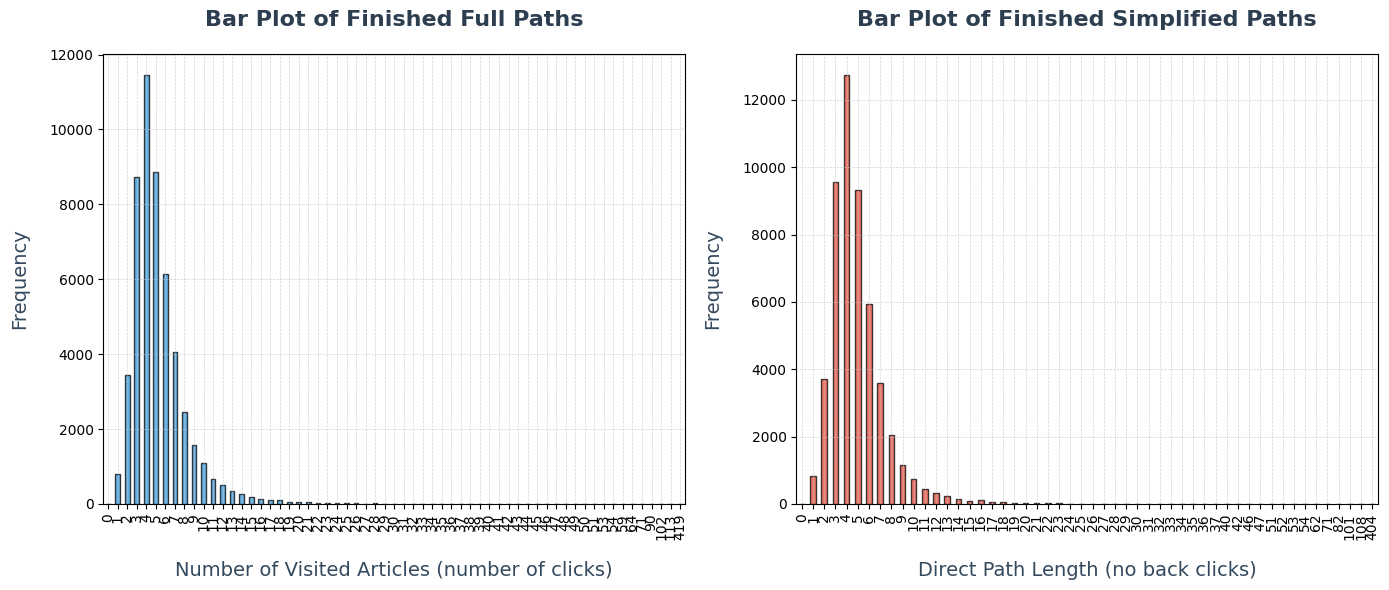

After filtering:


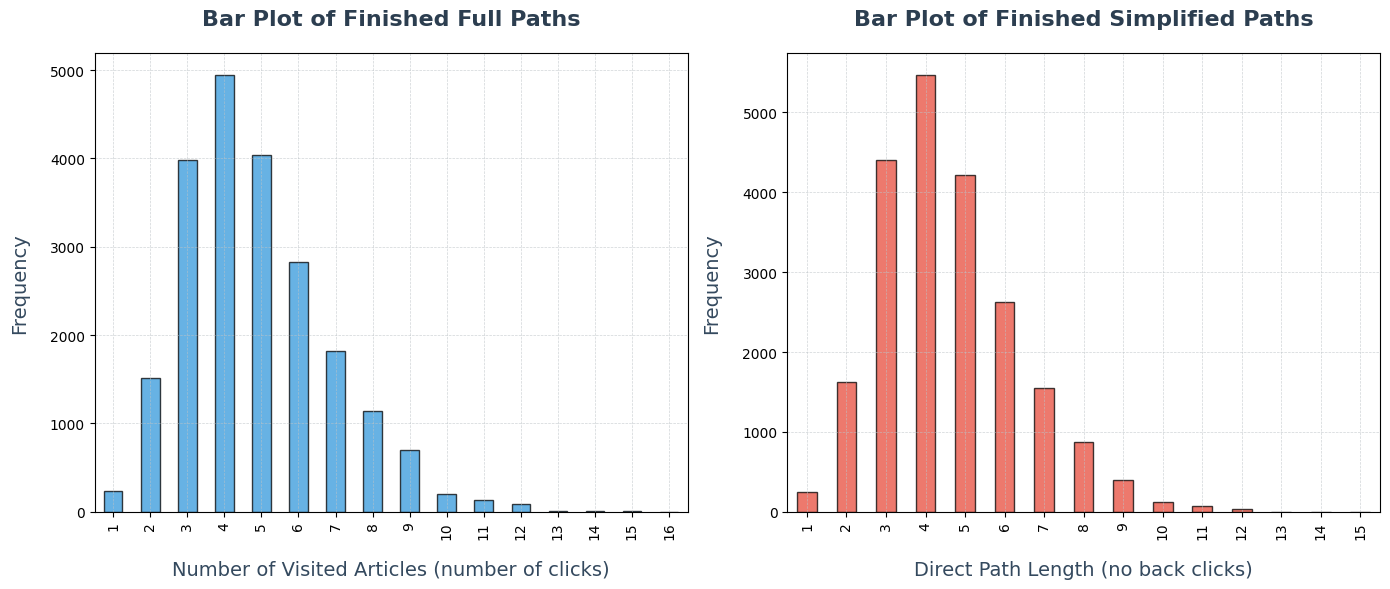

In [49]:
# Plot the histograms for full path and simpliefied path lengths prior to filtering
print("Prior to filtering:")
plot_path_length_distributions(finished_paths)

# And post filtering
print("After filtering:")
plot_path_length_distributions(length_filt_finished_paths)



This looks pretty good! While it may appear that the upper cutoff threshold is a bit large, this is simply due to these plots looking at the global path length distributions, while we filter for each distance group individually. And since these groups are distributed differently, we will keep some sample with longer paths.  
Below the distance group distribtions are plotted. 

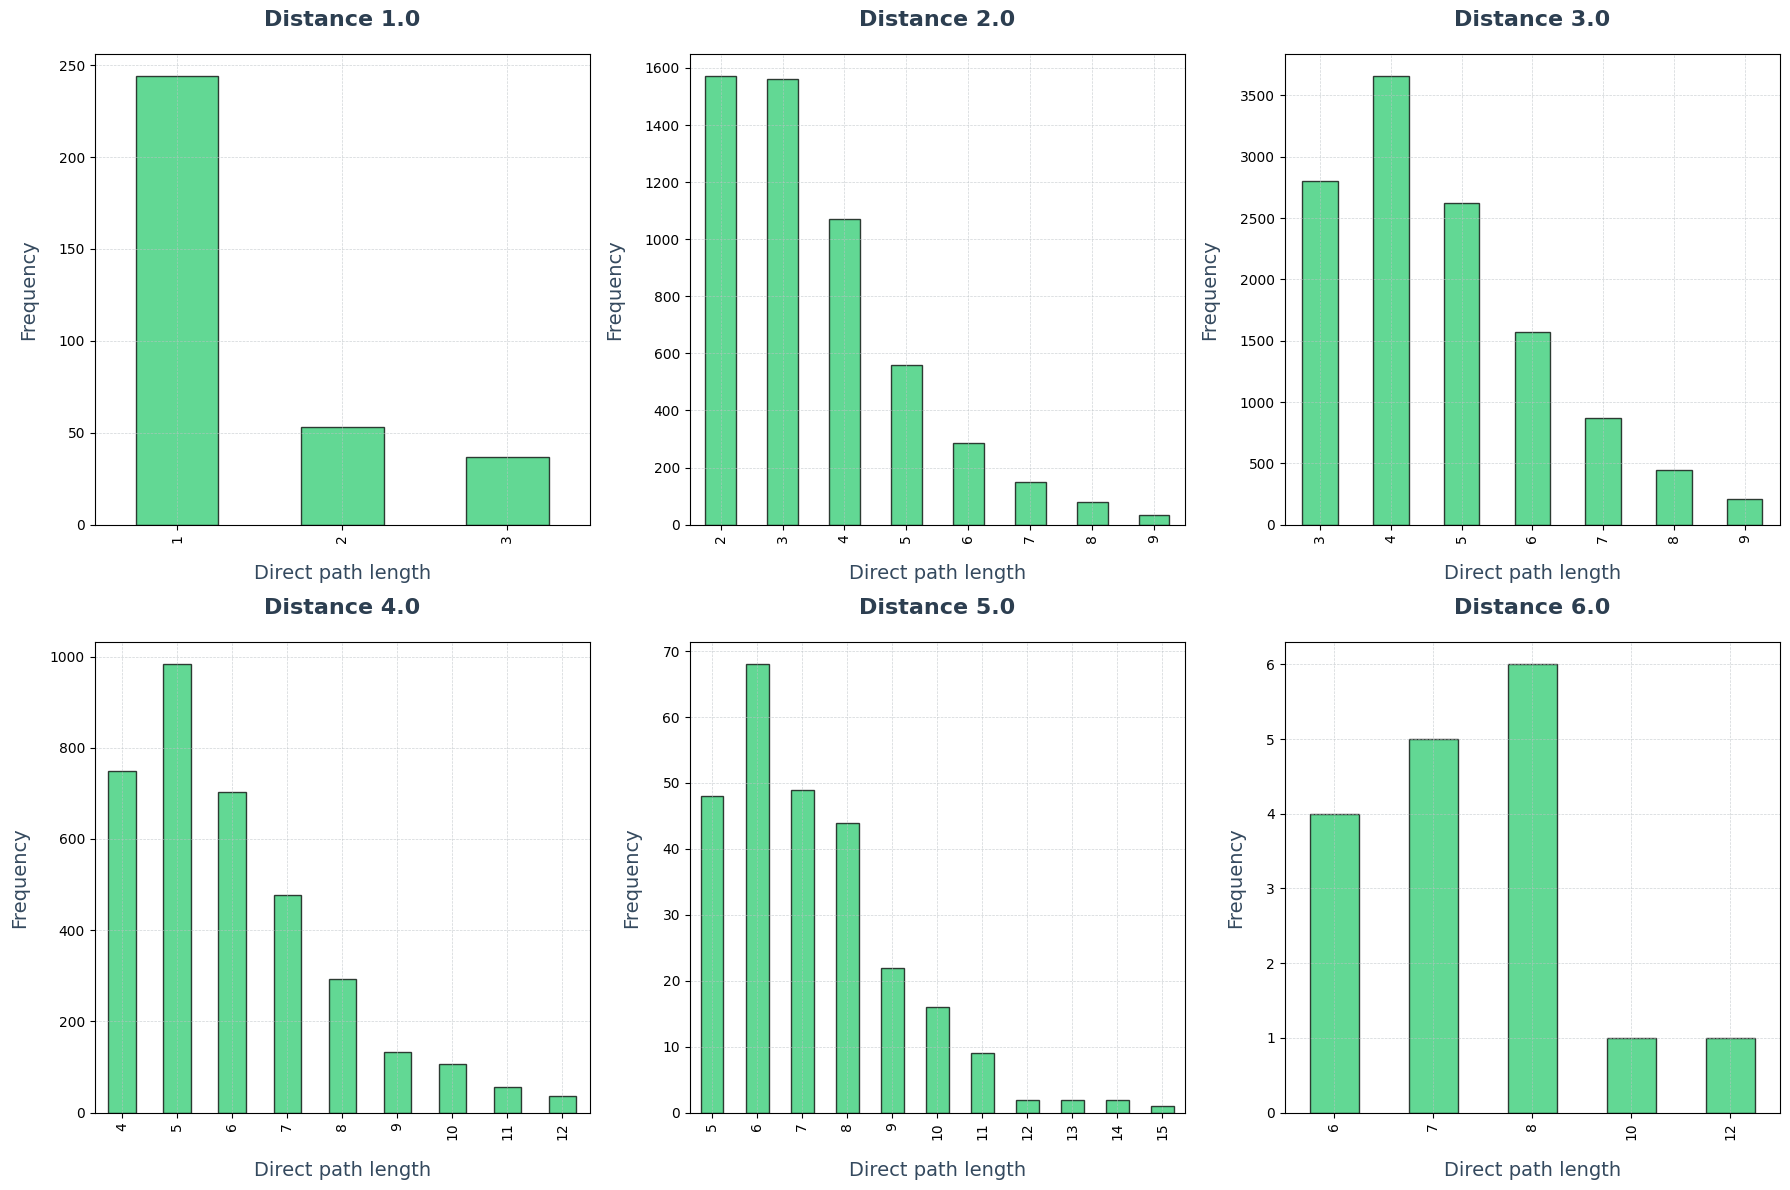

In [50]:
plot_by_distance(length_filt_finished_paths, 'simplified_path_length', x_label='Direct path length')

And now for the duration filtered finished paths...

Prior to filtering:


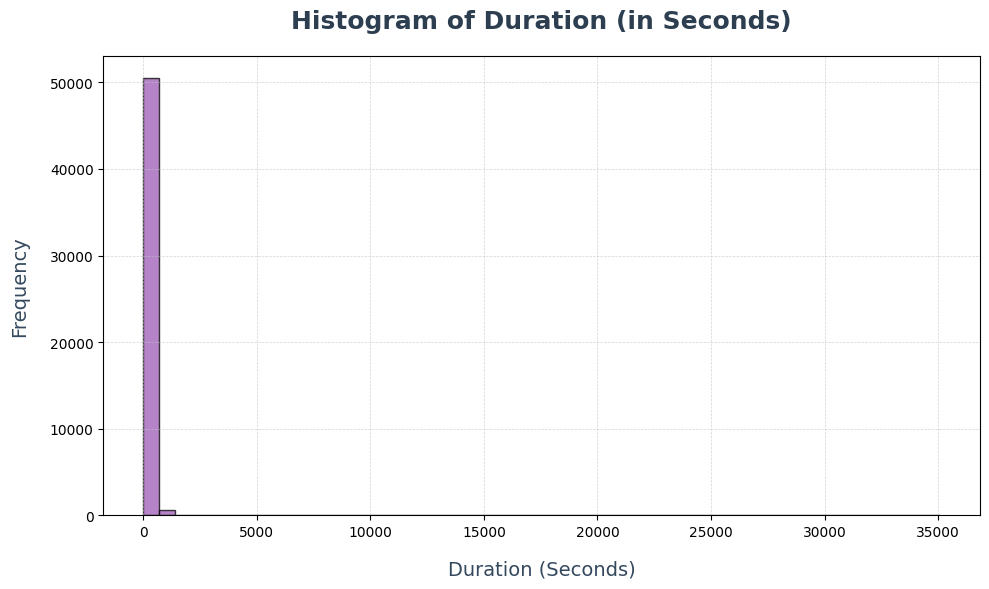

After filtering:


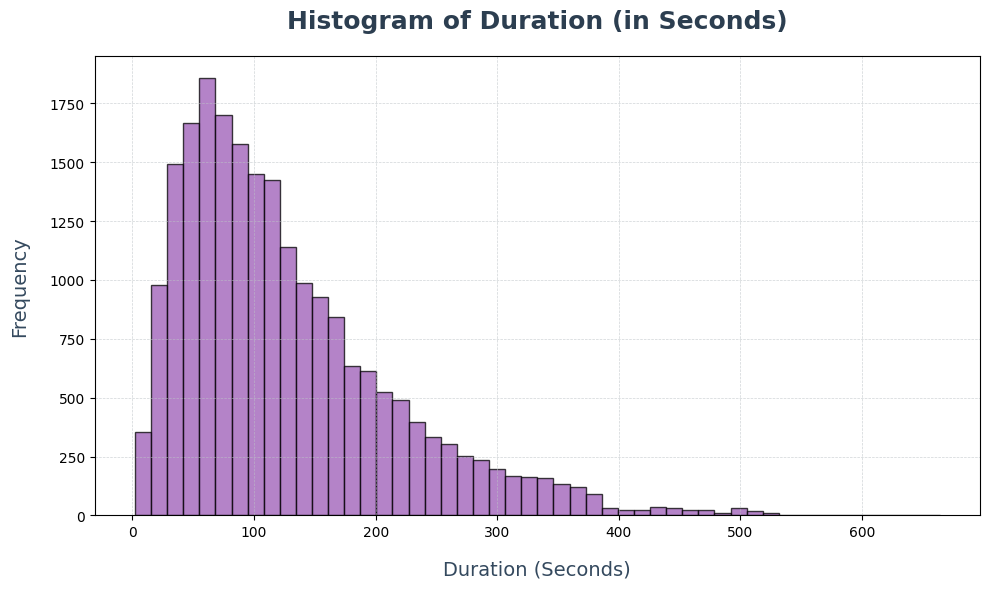

In [51]:
print("Prior to filtering:")
plot_duration_histogram(finished_paths, bins=50)

# And post filtering
print("After filtering:")
plot_duration_histogram(time_filt_finished_paths, bins=50)

Again the distribution has a long tail which is due to the seperate IQR filtering for the different distance groups. The plots below show this.

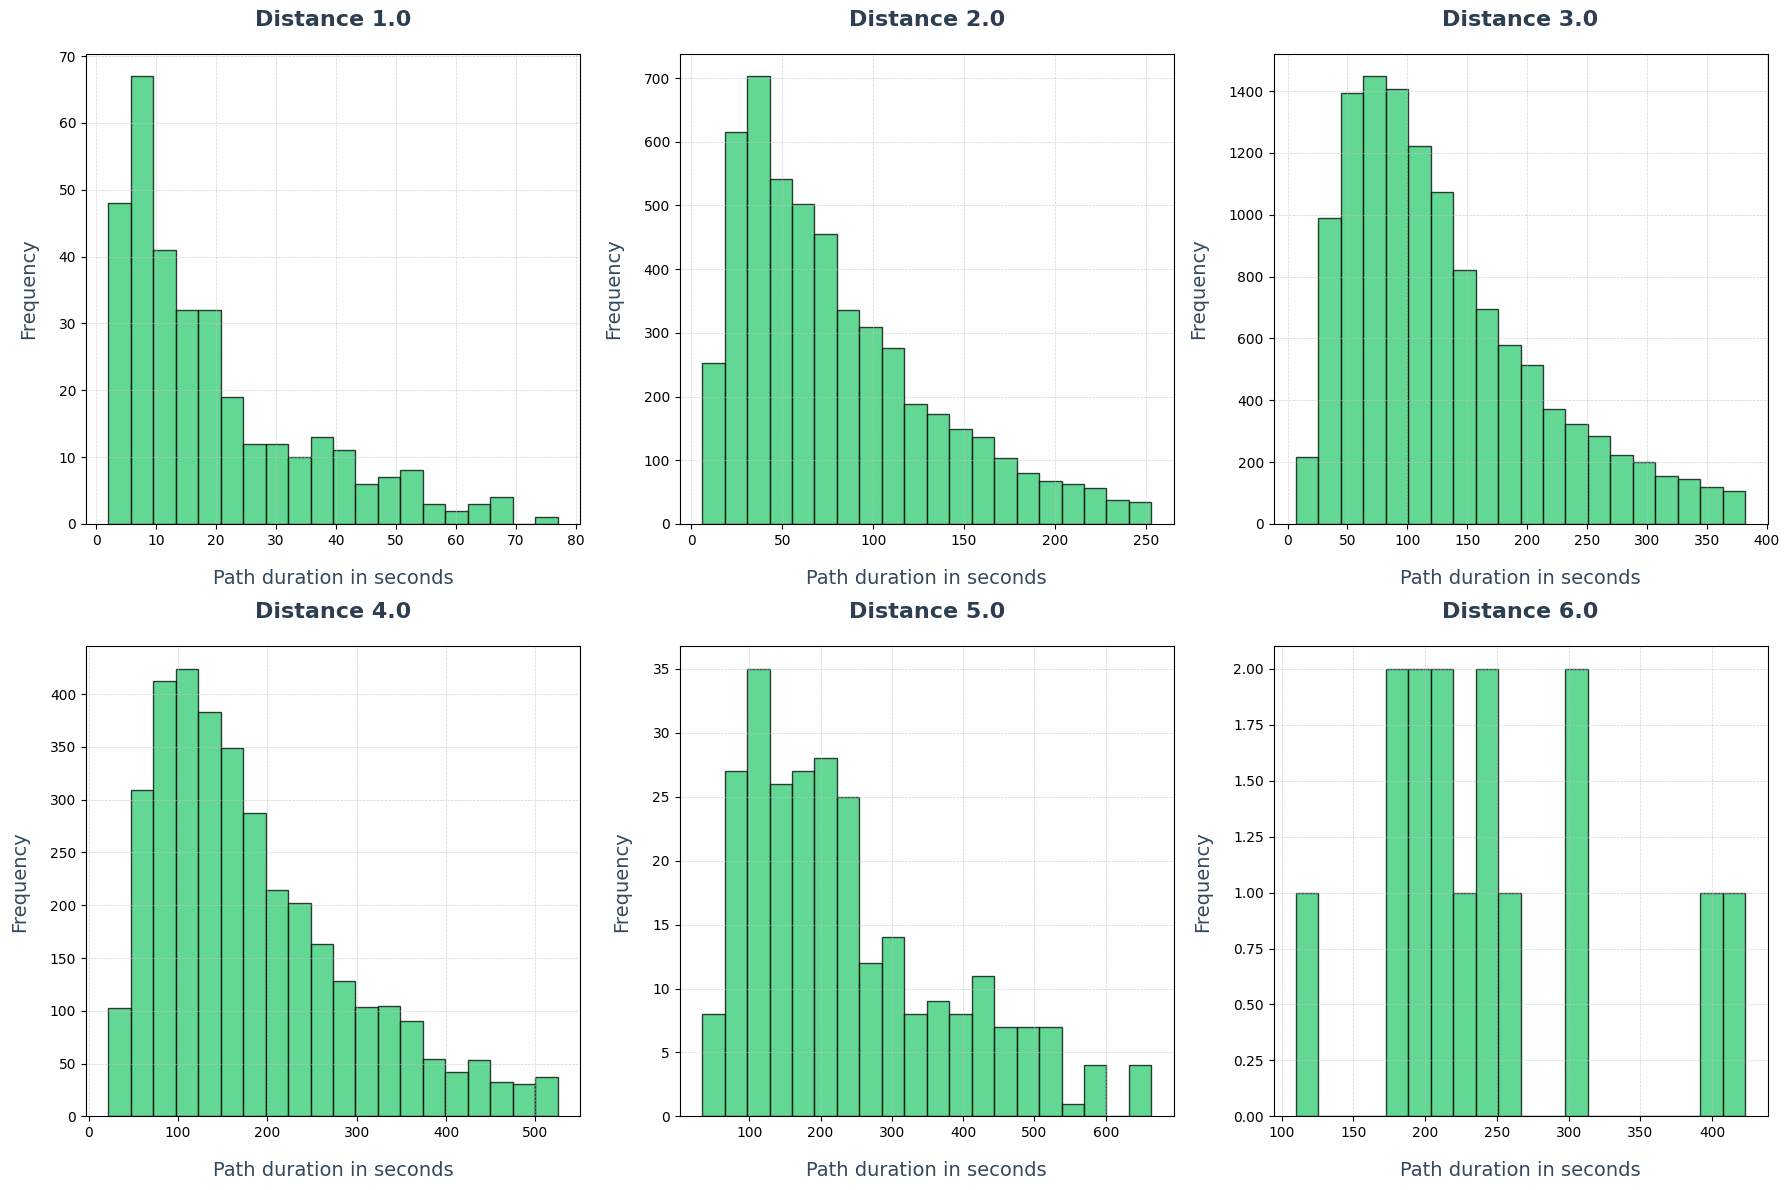

In [52]:
plot_by_distance(time_filt_finished_paths, 'durationInSec', x_label='Path duration in seconds', plot_type='hist', bins=20)

Now let's also have a look at the **unfinished paths**. We only consider the path length distribution, and not path duration. This is because unfishished paths are not used for duration based article scoring.

Prior to filtering:


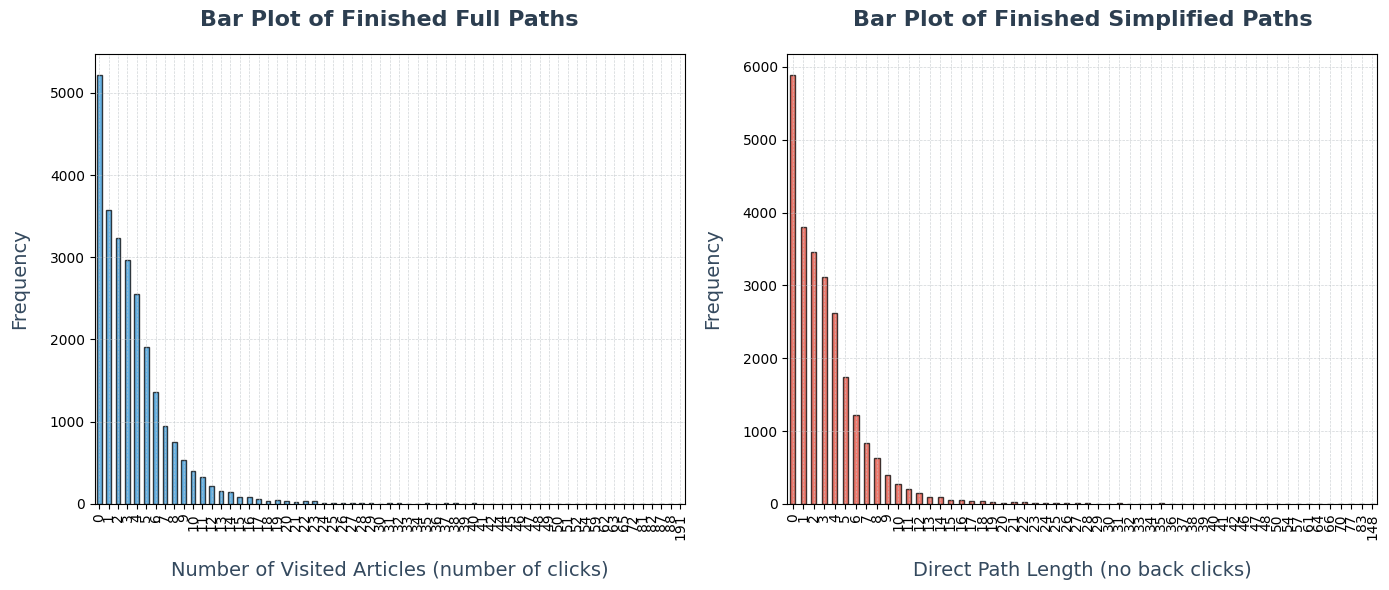

After filtering:


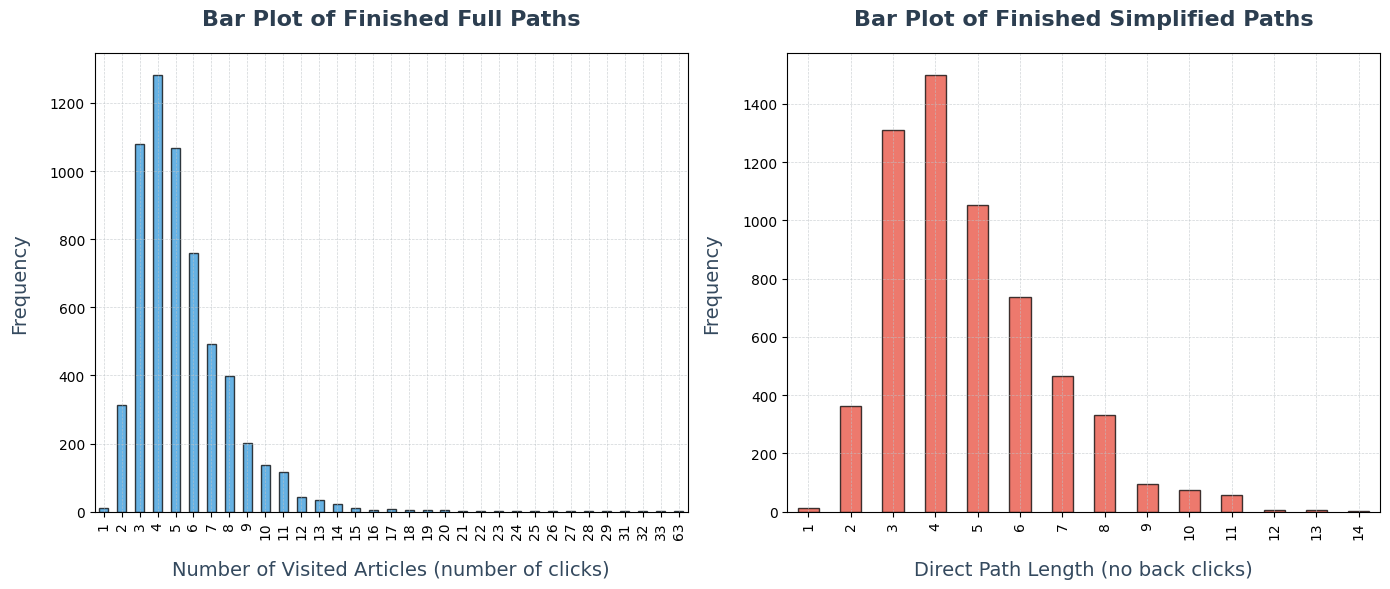

In [53]:
# Plot the histograms for full path and simpliefied path lengths prior to filtering
print("Prior to filtering:")
plot_path_length_distributions(unfinished_paths)

# And post filtering
print("After filtering:")
plot_path_length_distributions(filt_unfinished_paths)


# NEED TO CHANGE THE TITLE OF THE PLO!!!!!!!!!

 Again the histogram suggests that the filtering is reasonable.

For comparison let's also have a look at the distribution of the shortest possible distance distribution and its statistic. 

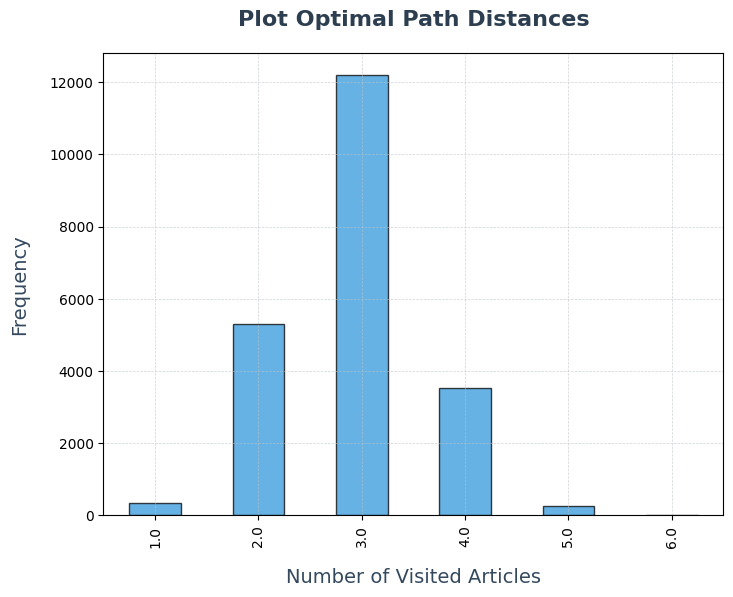

In [55]:
# plot the distribution of the shortest possible path lengths
distance_counts = length_filt_finished_paths['distance'].value_counts().sort_index()
plot_styled_bar_chart(distance_counts, title="Plot Optimal Path Distances", x_label="Number of Visited Articles", y_label="Frequency")

**Interesting observatin**

We just obversed that pretty much any article is reachable within at most 6 clicks (3 exeption with distance 7). This is interesting when we thik of the six degrees of separation idea...

## 1.3 Additional Findings in Path Processing

### Backup Dataframes for scoring

During the data filtering process, we noticed that while most start-target article pairs were played only a few times, there were some pairs that appeared more than 1000 times. To prevent these highly frequent pairs from disproportionately influencing article scores, we set a threshold (5) to downsample these pairs, in the filtering explained above.

However, we also want to use the data for the heavily repeated pairs to compute backup article scores. These scores won't reflect the global popularity or quality of an article, but rather its performance within a subset of the data. Specifically, the games where the pairings have been played very frequently. We expect these backup scores to be more robust for cases where the global scores might not perform well, serving as a proof of concept for when the global article scores fall short.

- `top_1_paths`: start-target pairs with the most samples.
- `top_4_paths`: start-target pairs with more than 1000 samples.

In [17]:
top1_paths, top4_paths, top10_paths = backup_dataframes(paths_df)

# Filter with a very large threshold so no dowsampling is done

# filterering for backup top4 dataframe
print("Filtering for top 1 start-target pair:")
path_filt_top1, filt_unfinished_top1, time_filt_top1 = filter_paths(top1_paths, sampling_threshold=10000)
print("-"*50)

print("Filtering for top 4 start-target pairs:")
path_filt_top4, filt_unfinished_top4, time_filt_top4 = filter_paths(top4_paths, sampling_threshold=10000)
print("-"*50)

#print("Filtering for top 10 start-target pairs:")
#path_filt_top10, time_filt_top10, filt_unfinished_top10 = filter_paths(top10_paths, sampling_threshold=10000)
#print("-"*50)

Filtering for top 1 start-target pair:
--------------------------------------------------
In path length filtering a total of 73 paths were removed from the finished paths, which represents 7.019% of the original finished data.  854 paths remain.
--------------------------------------------------
In path length filtering a total of 636 paths were removed from the unfinished paths, which represents 63.347% of the original unfinished data.  287 paths remain.
--------------------------------------------------
In path time filtering a total of 63 paths were removed from the finished paths, which represents 6.058% of the original finished data.  864 paths remain.
--------------------------------------------------
--------------------------------------------------
Filtering for top 4 start-target pairs:
--------------------------------------------------
In path length filtering a total of 169 paths were removed from the finished paths, which represents 4.656% of the original finished data.  

In [18]:
# store the filtered dataframes as feather files

path_filt_top1.to_feather('Data/dataframes/path_filt_top1_paths.feather')
time_filt_top1.to_feather('Data/dataframes/time_filt_top1_paths.feather')
filt_unfinished_top1.to_feather('Data/dataframes/filt_unfinished_top1.feather')

path_filt_top4.to_feather('Data/dataframes/path_filt_top4_paths.feather')
time_filt_top4.to_feather('Data/dataframes/time_filt_top4_paths.feather')
filt_unfinished_top4.to_feather('Data/dataframes/filt_unfinished_top4.feather')

"""
path_filt_top10.to_feather('Data/dataframes/path_filtered_top10_paths.feather')
time_filt_top10.to_feather('Data/dataframes/time_filtered_top10_paths.feather')
filt_unfinished_top10.to_feather('Data/dataframes/unfinished_top10_paths.feather')
"""

"\npath_filt_top10.to_feather('Data/dataframes/path_filtered_top10_paths.feather')\ntime_filt_top10.to_feather('Data/dataframes/time_filtered_top10_paths.feather')\nfilt_unfinished_top10.to_feather('Data/dataframes/unfinished_top10_paths.feather')\n"

### Race For Fastest Path

While coming up with the best way to filter based on path duration, we came accross an interessting obvervation...

# Part 2: Article Scoring

Bellow we explain different scores that we cam up with to quantize artilce "goodness" in the game.

***Prioritizing Scores Based on Minimal Clicks*** 

### **Difference Between Played Path Length and Optimal Distance**  
- **Optimal Distance**: The shortest possible distance from the start to the target article.  
- **Played Path Length**: The actual number of clicks (or visited articles - 1). This is represented in the dataset as `simplified_path_length`.  
- Why use `simplified_path_length` instead of `full_path_length`?  
  Simplified paths eliminate detours, thus only the articles relevant in finishing the path are taken into account.

We define the **Path Score** for a completed path as:  
$$
\mathbf{Path\ Score} = \frac{\text{Optimal\ Distance}}{\text{Simplified\ Path\ Length}}
$$  

This score ranges from 0 to 1, where 1 indicates the closest adherence to the optimal path. We refer to this score as the **path weight**, representing the ratio of actual path length to optimal distance.

#### **Article Scoring Based on Path Weights**  
After computing path weights for all completed paths, we use them to derive article scores using two approaches:

1. **Weighted Average**  
   Compute the average path weight for each article across all paths it appears in:  
   $$
   \mathbf{Article\ Score} = \frac{\sum_{i=1}^n w_i}{n}
   $$  
   where  $w_1, w_2, \dots, w_n$ are the path weights, and  $n$ is the number of paths the article appears in.  
   - This score is about article quality over quantity.
   - Only articles with a minimum appearance threshold are included to ensure meaningful scores.  
   - **Function**: `calculate_avg_article_weights(df, count_cutoff=30, scaling=None)`  

2. **Sum of Centered Weights**  
   - **Centering**: First, compute the mean article weight across all paths:  
     $$
     \text{Mean\ Article\ Weight} = \frac{\sum_{i=1}^N (\text{path}_i\ \text{weight} \times \text{num\_artcicles\_in\_path}_i)}{\sum_{i=1}^N \text{num\_artcicles\_in\_path}_i}
     $$  
     where $N$ is the total number of paths (or a downsampled subset), and $\text{num\_artcicles\_in\_path}_i$ the number of articles in simplified path $i$ (without start and target article).

   - **Centered Weights**:  
     $$
     \mathbf{Centered\ Weight} = \mathbf{Path\ Score} - \text{Mean\ Article\ Weight}
     $$  
     Why center using article weight and not path weight? Because in the end, we are interested in computing article weights, and since paths don't have the same number of articles, the average path weight is not the same as the average article weight.

   - Compute the article score by summing all centered weights for the paths the article appears in:  
     $$
     \mathbf{Article\ Score} = \sum_{i=1}^n cw_i
     $$  
     where $cw_1, cw_2, \dots, cw_n$ are the centered weights.  
   - This score balances quality and usefulness within the game, as articles that have high usage (appear often), appearing mostly in paths with an above 0 centered weight, will obtain the largest scores.
   - Only articles with a minimum appearance threshold are included to ensure meaningful scores.  
   - **Function**: `calculate_sum_article_cweights(df, count_cutoff=30, scaling=None)`

---

## Scores Based on Article Appearance in Detours  

### **Detour Ratio**  
- Detours occur when articles are backtracked (i.e don't appear in simplified paths).  
- For each article  $i$, the **Detour Ratio** is:  
  $$
  \mathbf{DetourRatio_i} = \frac{\text{detour\_count}_i}{\text{total\_appearances}_i},
  $$  

  where the $\text{detour\_count}_i$ and $\text{total\_appearances}_i$ are the number of appearance in detours and total number of apperances for article $i$ respectively.  
  This score caputres information that the is not present in the weighted average or sum of centered weight scores, and is thus well suited to make a composite score.
- Only articles with a minimum total appearance threshold are considered.  
- **Function**: `calculate_detour_ratios(df, count_cutoff=30, scaling=None)`  

---

## Scores Based on Article Presence in Unfinished Paths  

### **Unfinished Ratio**  
- Measures how frequently an article appears in incomplete paths.  
- For each article $i$, the **Unfinished Ratio** is:  
  $$
  \mathbf{UnfinishedRatio_i} = \frac{\text{unfinished\_count}_i}{\text{total\_appearances}_i}
  $$  

- This score also captures information that is the scores above don't, thus making it good for composite scoring.
- Again, articles must meet a minimum appearance threshold for meaningful scores.  
- **Function**: `calculate_unfinished_ratios(df, count_cutoff=30, scaling=None)`  

**========================================================================================================================================**

***Now Consider Scores That Reward Finishing the Game as Fast as Possible***

Our first approach was to compute path speeds from which article speed scores could be derived. We did not end up using these scores, but below is 

### **Weighted Average of Article Speed**  
We first compute **path speed**, defined as the time taken to complete the path (from `durationInSec`) divided by `full_path_length`. Similar to the weighted average of path weights, we can compute the average speed for each article. This involves extracting all $n$ paths an article appears in and calculating the average of the associated path speeds $s_1, s_2, \dots, s_n$:  
$$
\mathbf{Article\ Speed} = \frac{\sum_{i=1}^n s_i}{n}
$$  

Where $s_1, s_2, \dots, s_n$ are the path speeds, and $n$ is the number of paths containing the article.  

- Only articles with a minimum total appearance threshold are included for meaningful scores.  
- **Function**: `calc_avg_article_speed(df, count_cutoff=30, scaling=None)`  

---

### **Sum of Centered Article Speed**  
This approach mirrors the **sum of centered weights** but uses **path speed** instead of path weight.  

1. **Centering**: Compute the mean path speed across all paths:  
   $$
   \text{Mean\ Path\ Speed} = \frac{\sum_{i=1}^N (\text{path}_i\ \text{speed} \times \text{full\_path\_length}_i)}{\sum_{i=1}^N \text{full\_path\_length}_i}
   $$  
   where $N$ is the total number of paths (or a downsampled subset).  

2. **Centered Speeds**:  
   $$
   \mathbf{Centered\ Speed} = \mathbf{Path\ Speed} - \text{Mean\ Path\ Speed}
   $$  

3. Compute the article score by summing all centered speeds for the paths the article appears in:  
   $$
   \mathbf{Article\ Score} = \sum_{i=1}^n cs_i
   $$  
   where $cs_1, cs_2, \dots, cs_n$ are the centered speeds, and $n$ is the number of paths the article appears in.  

- This score provides a balance between high speed and frequency of appearances. 
- **Function**: `calc_sum_article_cspeed(df, count_cutoff=30, scaling=None)`  

---  
***Imporant note about the scaling***  
The functions are all coded in a way that when scaling is applied to the scores, large values always are better. So for example, even if the ratio of unfinished paths should be as small as possible, the sacled score column, is flipped, so that larger means better. This way when different scores are combined in a composite score, bigger is also always better.

---  

In [1]:
# temp cell so i don't have to rerun everything
from src.utils.score_utils import *
from src.scripts.scores import compute_scores_df, calculate_composite_scores, compute_binary_scores

import pandas as pd
import numpy as np
from pyarrow.feather import read_feather
import seaborn as sns
from src.utils.helpers import plot_scaled_score_correlations, perform_pca_and_plot, interactive_scatter

In [2]:
# temp cell so i don't need to run everything all the time
length_filt_finished_paths = read_feather('Data/dataframes/length_filt_finished_paths.feather')
time_filt_finished_paths = read_feather('Data/dataframes/time_filt_finished_paths.feather')
filt_unfinished_paths = read_feather('Data/dataframes/filt_unfinished_paths.feather')

# also the backup dataframes
path_filt_top1 = read_feather('Data/dataframes/path_filt_top1_paths.feather')
time_filt_top1 = read_feather('Data/dataframes/time_filt_top1_paths.feather')
filt_unfinished_top1 = read_feather('Data/dataframes/filt_unfinished_top1.feather')

path_filt_top4 = read_feather('Data/dataframes/path_filt_top4_paths.feather')
time_filt_top4 = read_feather('Data/dataframes/time_filt_top4_paths.feather')
filt_unfinished_top4 = read_feather('Data/dataframes/filt_unfinished_top4.feather')

Compute the scores for the filtered data sets

In [3]:
# This can take over a minute to run
click_scores_df, time_scores_df = compute_scores_df(length_filt_finished_paths, 
                              pd.concat([length_filt_finished_paths, filt_unfinished_paths]),
                              time_filt_finished_paths, 
                              count_cutoff=30,
                              scaling='standard')

Calculating click related scores...
Ratio of unfinished over total paths: 0.21736929640610314
Calculating speed related scores...
Number of unique articles in click score df: 627
Number of unique articles in speed score df: 664


## 2.1 Score anaylsis

### Check how the scores are correlated
If we want to define reasonable composite scores we should do some anaylsis on the relation between the scores.

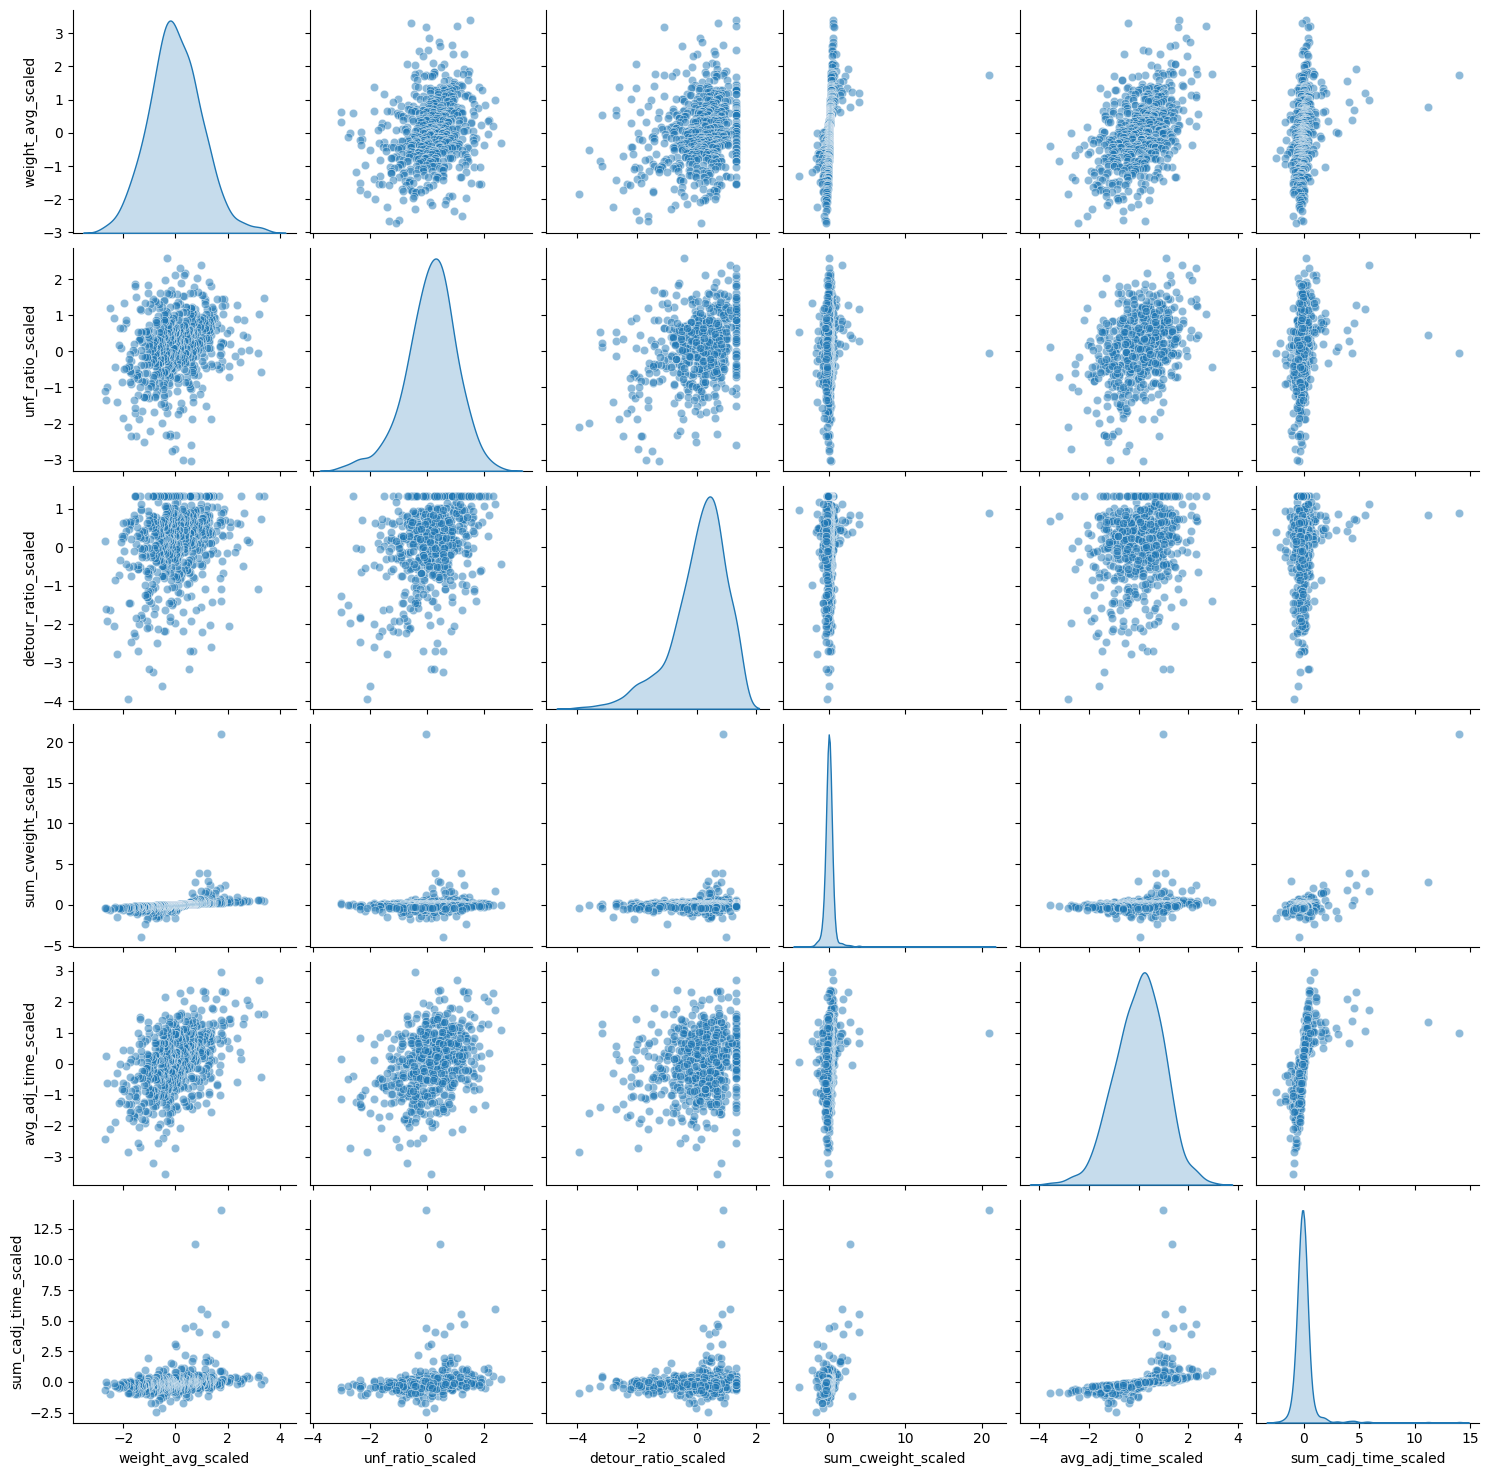

In [4]:
scores_df = pd.merge(click_scores_df, time_scores_df, on='article', suffixes=('_click', '_time'))
plot_scaled_score_correlations(scores_df)

**Comment (to redo later)**

In the sum of centered weight and speed scores, there are clear outliers, this is not really a surprise as article that appear a lot more often, can have very large/small values in these scores. Maybe these extreme values should be removed for ML tasks.

There does not appear to be any clear correlation, which is a bit surprising, but also indicates that the different scores are not redundant

In [5]:
# modifier cetter fronction pout que les titres et label des axes soient plus clairs
interactive_scatter(scores_df, 'weight_avg_scaled', 'avg_adj_time_scaled', count_col='n_appearances_click')
interactive_scatter(scores_df, 'sum_cweight_scaled', 'sum_cadj_time_scaled', count_col='n_appearances_click')


**COMMENT TO ADD**

## Determining a meaningfull composite score

We would now like to combine some of the scores as they capture different aspects of the data. 
the scores that make sense to combine (after scaling) are:
- `weighted_avg`, `detour_ratio`, and `unfinished_ratio`
- `weighted_avg` and `detour_ratio`
- `sum_cweights`, `detour_ratio`, and `unfinished_ratio`
- `sum_cweights` and `detour_ratio`

Ideally, we would do so using a data driven approach. (**refine text**)

- First evaluate if PCA can be used to combine the scores
    by only considering the first principle component (PC1), we can potentially, combine mulitple scores. However, this only makes sense if the PC1 captures a large portion of the variance.
- Weighted Sum: combine the scores giving the a weight.


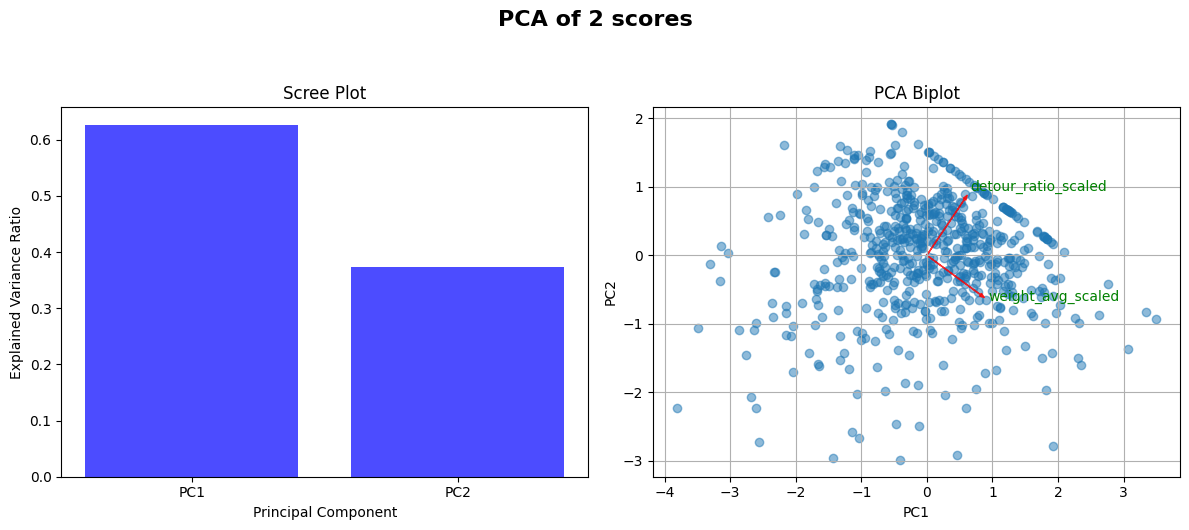

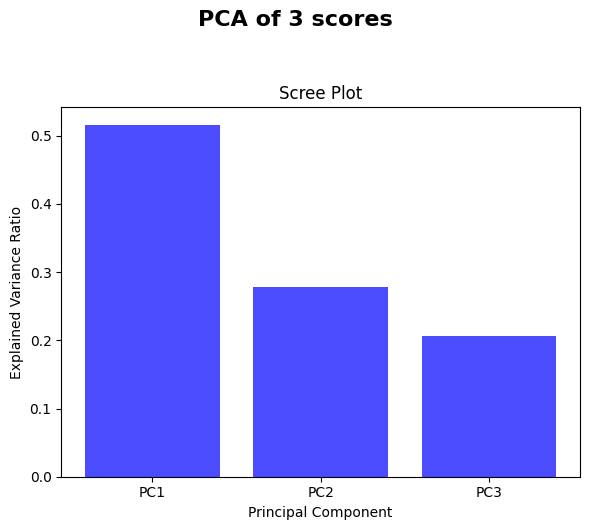

In [6]:
pca2, pca_components2 = perform_pca_and_plot(scores_df, components = ['weight_avg_scaled', 'detour_ratio_scaled'], biplot=True, title='PCA of 2 scores')
pca3, pca_components3 = perform_pca_and_plot(scores_df, components = ['weight_avg_scaled', 'detour_ratio_scaled', 'unf_ratio_scaled'], title='PCA of 3 scores', biplot=False)

**Comment**

A rule of thumb is that the first principle component should capture at least 70% of the variance, if we want to use it for our composite scores. In both cases, it is below that, so it is probably not ideal as to much information would be lost in such a dimensionality reduction. but the combined score of only 2 metrics is close so we also consider it...

## Alternative: weighted sum of the scores.

The **weighted sum score** is calculated by combining individual scores, each multiplied by their respective weight. The formula is as follows:


$$
\text{Composite Score} = (w_1 \cdot score_1) + (w_2 \cdot score_2) + (w_3 \cdot score_3)
$$


We first tried an other more data-driven approach, where the idea was that weights are assigned accroding to the the amount of variance of the score. So, the larger the variance the larger the score's weight i.e contribution to the composite score. However, we did not decide to use this method as in our opinion it results in an unreasonably large contribuion of the unfinished ratio score. This is because overall, after filtering, the unfinished paths data represents a small fraction of the total filtered data, and there is still no guarante that the player really 'tried' in those attempts.


### Define Custom Weight for Composite Scores

This might at first appear quite arbitrary. But the data driven approaches don't appear to make the most sense, and since these scores are defined by us in the first place, it is not so far fetched that we also define how to weight them to get a composite score.
We thus defines set:

- $w_1 = 0.55$ (Weight for average scaled value)
- $w_2 = 0.25$ (Weight for detour ratio scaled)
- $w_3 = 0.2$ (Weight for unfinished ratio scaled)

$$
quality_3 = w_1 \cdot \text{avg\_weight\_scaled} + w_2 \cdot \text{detour\_ratio\_scaled} +  w_3 \cdot \text{unf\_ratio\_scaled}
$$

$$
utility_3 = w_1 \cdot \text{sum\_cweight\_scaled} + w_2 \cdot \text{detour\_ratio\_scaled} + w_3 \cdot \text{unf\_ratio\_scaled}
$$

and

- $w_1 = 0.65$ (Weight for average scaled value)
- $w_2 = 0.35$ (Weight for detour ratio scaled)


$$
quality_2 = w_1 \cdot \text{avg\_weight\_scaled} + w_2 \cdot \text{detour\_ratio\_scaled}
$$

$$
utility_2 = w_1 \cdot \text{sum\_cweight\_scaled} + w_2 \cdot \text{detour\_ratio\_scaled}
$$

Note that the difference between **quality** and **utility** compoiste scores is that in one we consider the weighted average and in the other the sum of centered average weights.


In [7]:
quality_scores_clicks, utility_scores_clicks = calculate_composite_scores(click_scores_df)

# for the speed related score we don't compute composite scores
time_scores = time_scores_df[['n_appearances', 'avg_adj_time_scaled', 'sum_cadj_time_scaled']].sort_values(by='avg_adj_time_scaled', ascending=False)

# store the scores dataframes as feather files
quality_scores_clicks.to_feather('Data/dataframes/quality_scores_clicks.feather')
utility_scores_clicks.to_feather('Data/dataframes/utility_scores_clicks.feather')
time_scores.to_feather('Data/dataframes/time_scores.feather')

**COMMENT WHAT IS BELOW**

In [8]:
df = pd.merge(quality_scores_clicks, time_scores, on='article', suffixes=('_quality', '_time'))
interactive_scatter(df, 'composite_3', 'avg_adj_time_scaled', count_col='n_appearances_quality', use_log=True)
df = pd.merge(utility_scores_clicks, time_scores, on='article', suffixes=('_utility', '_time'))
interactive_scatter(df, 'composite_3', 'sum_cadj_time_scaled', count_col='n_appearances_utility', use_log=True)

**COMMENT WHAT IS BELOW**

In [9]:
quality_binary, utility_binary, avg_time_binary, csum_time_binary = compute_binary_scores(quality_scores_clicks, utility_scores_clicks, time_scores)

### Exact same for backup datasets

maybe make a script for this and don't show the plots so everything is more consise.
If not need to add some comments here as well.

In [10]:
top_1_click_scores_df, top_1_time_scores_df = compute_scores_df(path_filt_top1,
                                    pd.concat([path_filt_top1, filt_unfinished_top1]),
                                    time_filt_top1,
                                    count_cutoff=30,
                                    scaling='standard',
                                    consider_start=False)

top_1_scores_df = pd.merge(top_1_click_scores_df, top_1_time_scores_df, on='article', suffixes=('_click', '_time'))

Calculating click related scores...
Ratio of unfinished over total paths: 0.25153374233128833
Calculating speed related scores...
Number of unique articles in click score df: 26
Number of unique articles in speed score df: 27


In [11]:
top_4_click_scores_df, top_4_time_scores_df = compute_scores_df(path_filt_top4,
                                    pd.concat([path_filt_top4, filt_unfinished_top4]),
                                    time_filt_top4,
                                    count_cutoff=30,
                                    scaling='standard',
                                    consider_start=False)

top_4_scores_df = pd.merge(top_4_click_scores_df, top_4_time_scores_df, on='article', suffixes=('_click', '_time'))

Calculating click related scores...
Ratio of unfinished over total paths: 0.3132133450395084
Calculating speed related scores...
Number of unique articles in click score df: 91
Number of unique articles in speed score df: 97


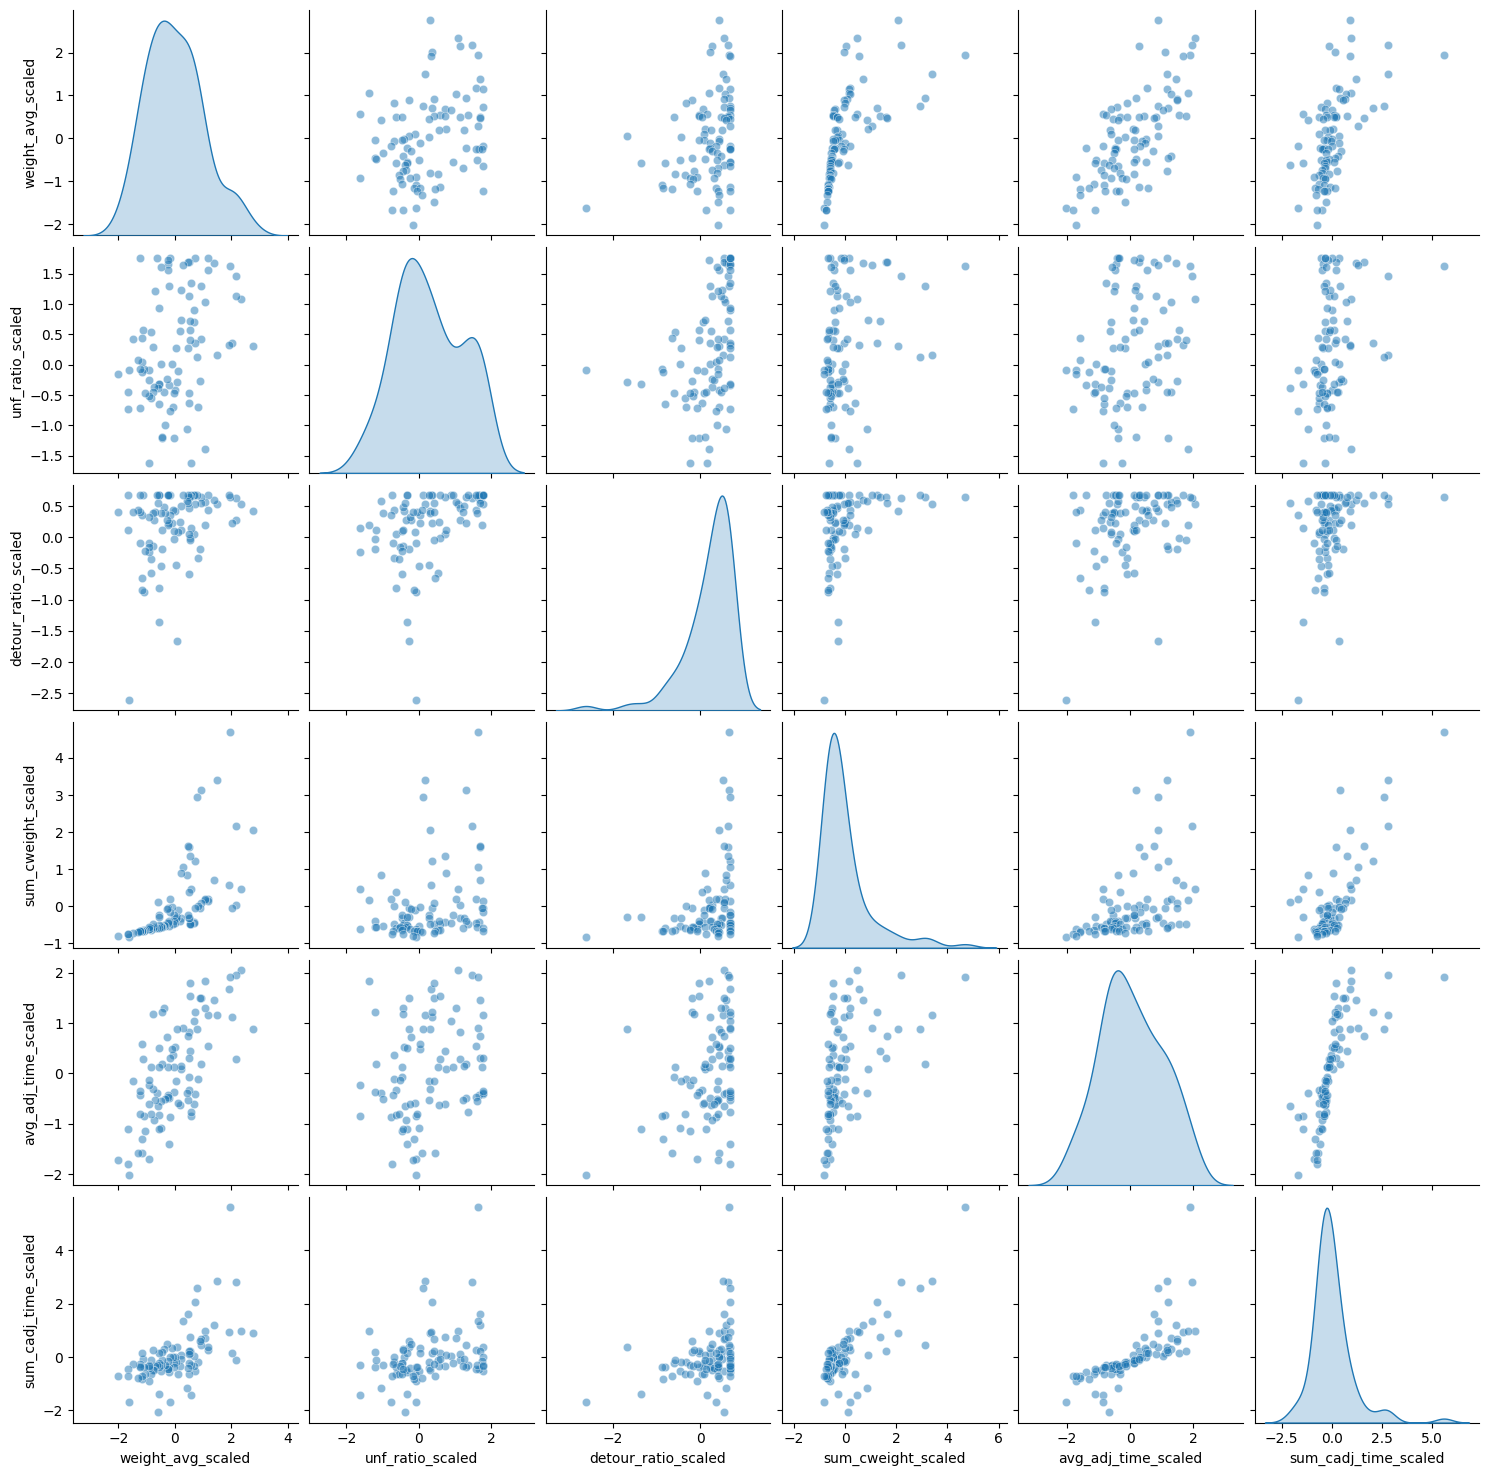

In [12]:
plot_scaled_score_correlations(top_4_scores_df)

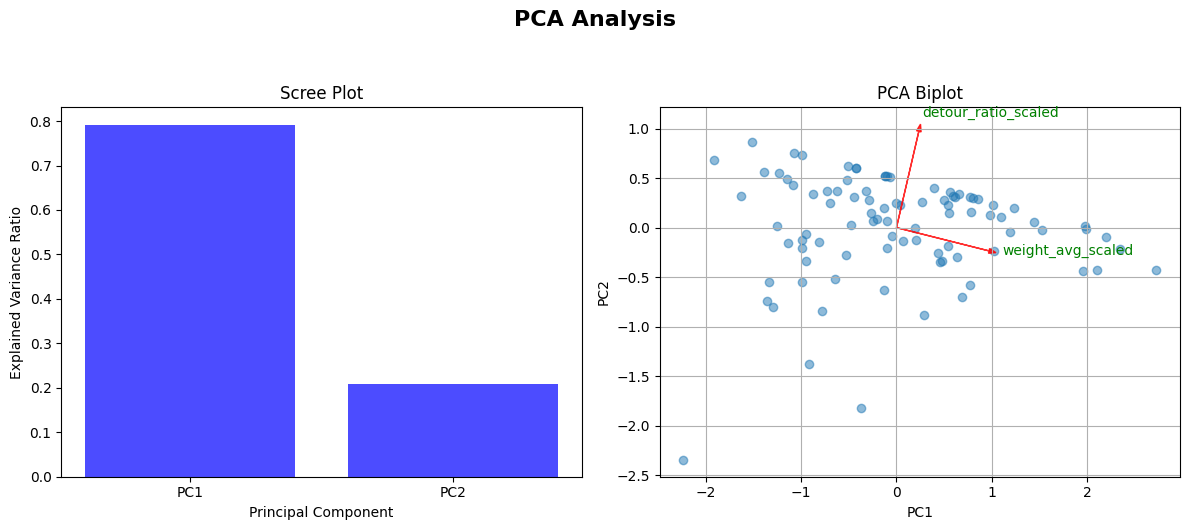

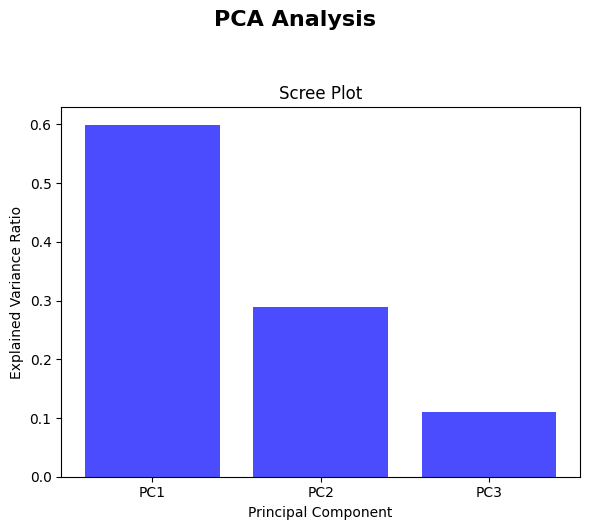

In [13]:
_, _ = perform_pca_and_plot(top_4_scores_df, components = ['weight_avg_scaled', 'detour_ratio_scaled'], biplot=True)
_, _ = perform_pca_and_plot(top_4_scores_df, components = ['weight_avg_scaled', 'detour_ratio_scaled', 'unf_ratio_scaled', ], biplot=False)

In [14]:
top4_quality_scores_clicks, top4_utility_scores_clicks = calculate_composite_scores(top_4_click_scores_df)
top4_scores_time = top_4_time_scores_df[['n_appearances', 'avg_adj_time_scaled', 'sum_cadj_time_scaled']]

top1_quality_scores_clicks, top1_utility_scores_clicks = calculate_composite_scores(top_1_click_scores_df)
top1_scores_time = top_1_time_scores_df[['n_appearances', 'avg_adj_time_scaled', 'sum_cadj_time_scaled']]

# store the scores dataframes as feather files
top_4_scores_df.to_feather('Data/dataframes/top_4_scores_df.feather')
top_4_click_scores_df.to_feather('Data/dataframes/top_4_click_scores_df.feather')
top_4_time_scores_df.to_feather('Data/dataframes/top_4_time_scores_df.feather')

top_1_scores_df.to_feather('Data/dataframes/top_1_scores_df.feather')
top_1_click_scores_df.to_feather('Data/dataframes/top_1_click_scores_df.feather')
top_1_time_scores_df.to_feather('Data/dataframes/top_1_time_scores_df.feather')

In [15]:
df = pd.merge(top4_quality_scores_clicks, top4_scores_time, on='article', suffixes=('_quality', '_time'))
interactive_scatter(df, 'composite_3', 'avg_adj_time_scaled', count_col='n_appearances_quality', use_log=False)
df = pd.merge(top4_utility_scores_clicks, top4_scores_time, on='article', suffixes=('_utility', '_time'))
interactive_scatter(df, 'composite_3', 'sum_cadj_time_scaled', count_col='n_appearances_utility', use_log=False)

.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  


# Part 3 Analysis of Article Data (qqn d'autre peut repasser sur ca svp)

In this section, we compute key article attributes. This will help us understand the distribution and variety within the data, providing a clearer picture of each article's features. Those attributes will Then be correlated with the article's scores computed above to understand what drives efficient navigation

In [37]:
from src.scripts.article_processing import add_incoming_links, add_num_hyperlinks, add_length_and_hyperlink_density, add_average_cosine_distance, add_vocabulary_richness
from src.utils.helpers import plot_incoming_links, plot_outgoing_links, plot_hyperlink_density, plot_article_length, plot_average_cosine_distance, plot_vocabulary_richness

### Incoming hyperlinks

Here, we focus on the attribute "incoming hyperlinks", which represents how easily an article can be reached from other articles in the network that have a one-way hyperlink to it.

Summary statistics for incoming links:
count    4604.000000
mean       26.038662
std        62.746827
min         0.000000
25%         2.000000
50%         8.000000
75%        25.000000
max      1551.000000
Name: incoming_links, dtype: float64


/Users/oscargoudet/.virtualenvs/ada-2024-project-adaholiks/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


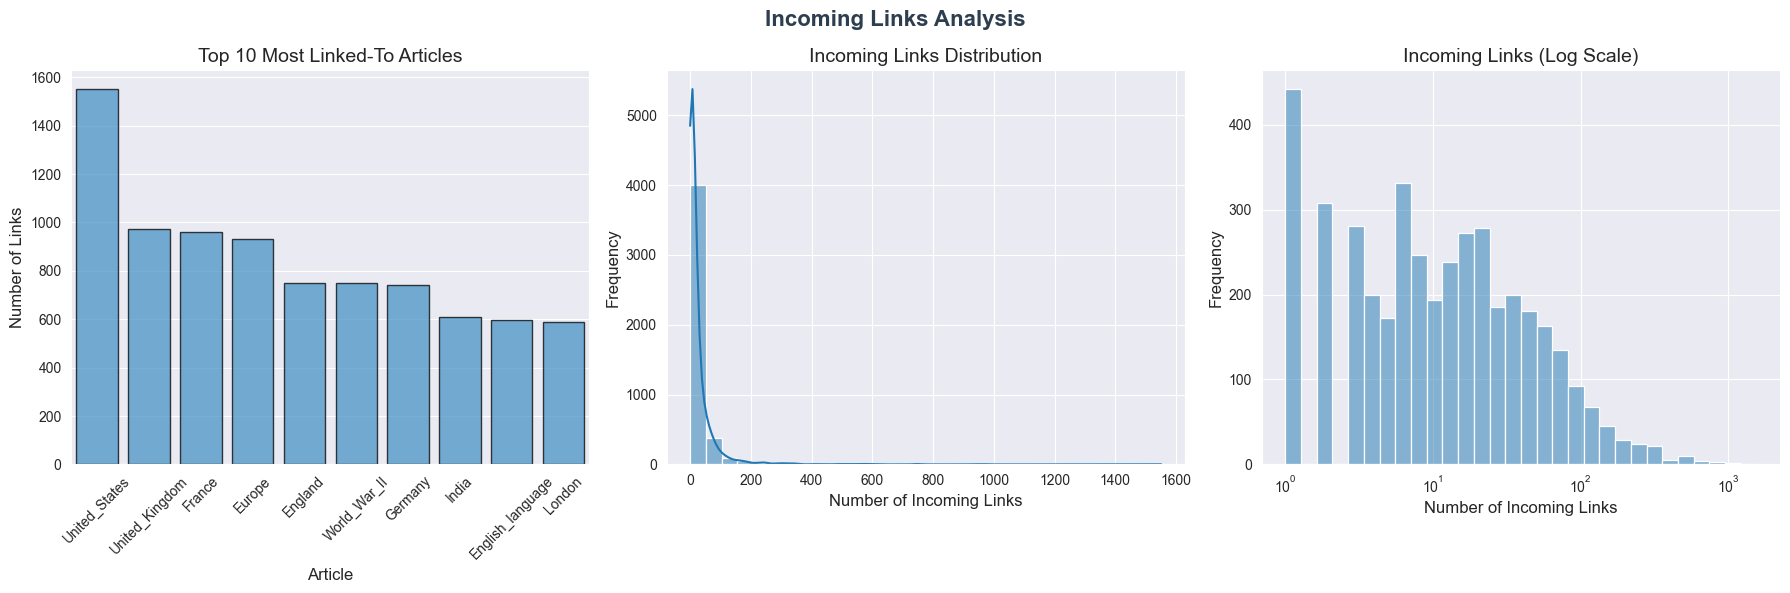

In [38]:
# Add new attributes
article_df = add_incoming_links(article_df)
# Generate plots
plot_incoming_links(article_df)


**Comment:** Here, we can observe that almost all of the top-linked articles are related to geography, geographical locations are often linked to a wide range of subjects which likely contributes to the higher number of incoming hyperlinks for these articles.
The distribution indicates that a small number of articles have a disproportionately large number of incoming links. compared to the rest of the network, these are the cenral hubs of the network ( e.g. United states article). With this heavy tail distribution we might think that it would be a good idea to filter out the outliers but in a systems like Wikispeedia (or any network), the heavy-tailed nature of link distributions is expected. Popular or highly connected articles likely play a central role in efficient navigation and removing any part of the distribution would skew our analysis and lead to biased results.

### Outgoing hyperlinks

Here, we focus on the attribute "outgoing hyperlinks", which represents how an article connects to other articles in the network through one-way hyperlinks.

Summary statistics for outgoing links:
count    4604.000000
mean       26.038662
std        24.201491
min         0.000000
25%        11.000000
50%        19.000000
75%        33.000000
max       294.000000
Name: num_hyperlinks, dtype: float64


/Users/oscargoudet/.virtualenvs/ada-2024-project-adaholiks/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


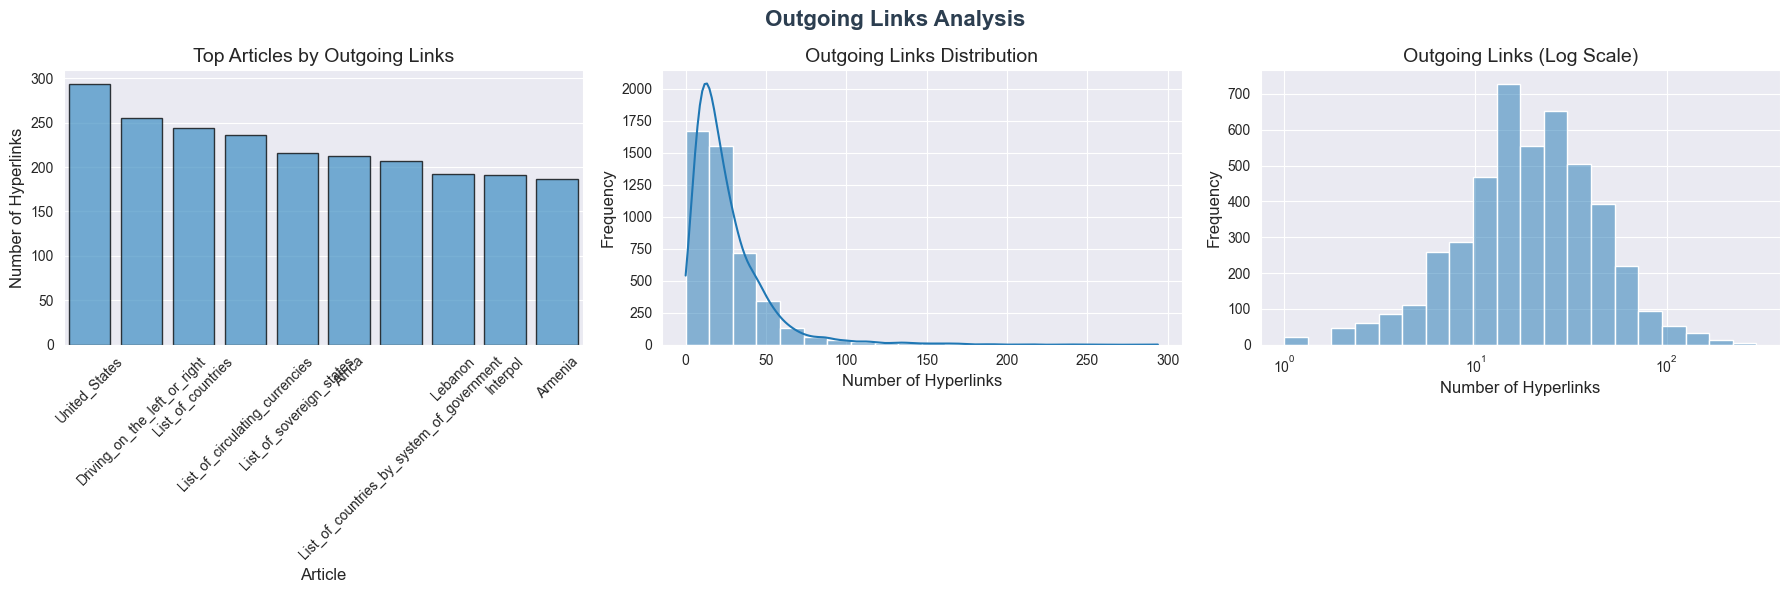

In [39]:
# Add new attributes
article_df = add_num_hyperlinks(article_df)
# Generate plots
plot_outgoing_links(article_df)

**Comment:** It’s interesting to see that the "United States" article is the most important node in our network. This article consistently ranks highly across different measures. It often appears in the shortest paths between articles and is a common stop in players’ successful games. Because of this, it’s not surprising that it also has the highest number of both incoming and outgoing hyperlinks. We can also notice that some articles, like "List_of_countries," are mostly collections of hyperlinks. These types of articles act as hubs or directories with lots of outgoing hyperlinks, which is why they stand out when looking at hyperlink numbers. The summary statistics and the above distribution reveal that the number of outgoing links varies widely across articles. Most articles have between 11 and 33 outgoing links. However, the mean of 26 and the standard deviation (24.2) indicate that some articles have significantly more links, as highlighted by the maximum of 294, again highlighting disproportionnality of number of links per article.



### Hyperlink density

Here, we now focus on the attribute "hyperlink density", which combines the length of an article with the number of outgoing hyperlinks it pocesses.

Summary statistics for hyperlink density:
count    4604.000000
mean        0.001604
std         0.001573
min         0.000000
25%         0.000727
50%         0.001208
75%         0.001953
max         0.025199
Name: hyperlink_density, dtype: float64


/Users/oscargoudet/.virtualenvs/ada-2024-project-adaholiks/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


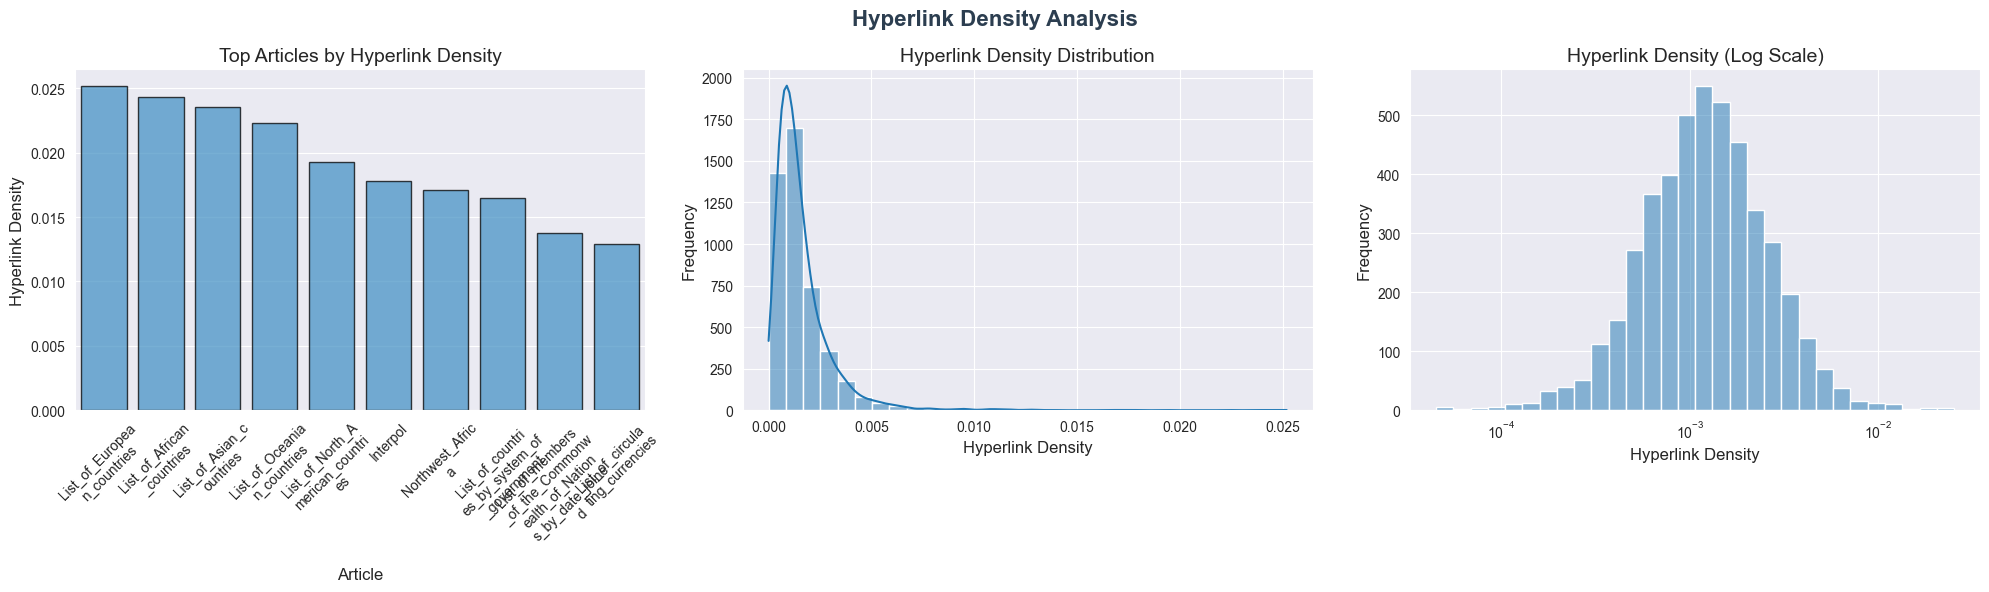

In [40]:
article_df = add_length_and_hyperlink_density(article_df)
plot_hyperlink_density(article_df)

**Comment:** We can see that all the articles with the highest hyperlink density are "List" articles. This makes sense, as these articles contain very little text, and nearly every item in the list is a hyperlink to another article. However, this suggests that hyperlink density might not be a reliable indicator of an article’s quality for efficient navigation.


### Number of characters

Here, we focus on the attribute "number of characters", which is an indication of the length of each article.

Summary statistics for number of characters:
count      4604.000000
mean      21232.968723
std       15508.639317
min         828.000000
25%        8811.750000
50%       17736.500000
75%       30104.750000
max      108718.000000
Name: num_characters, dtype: float64


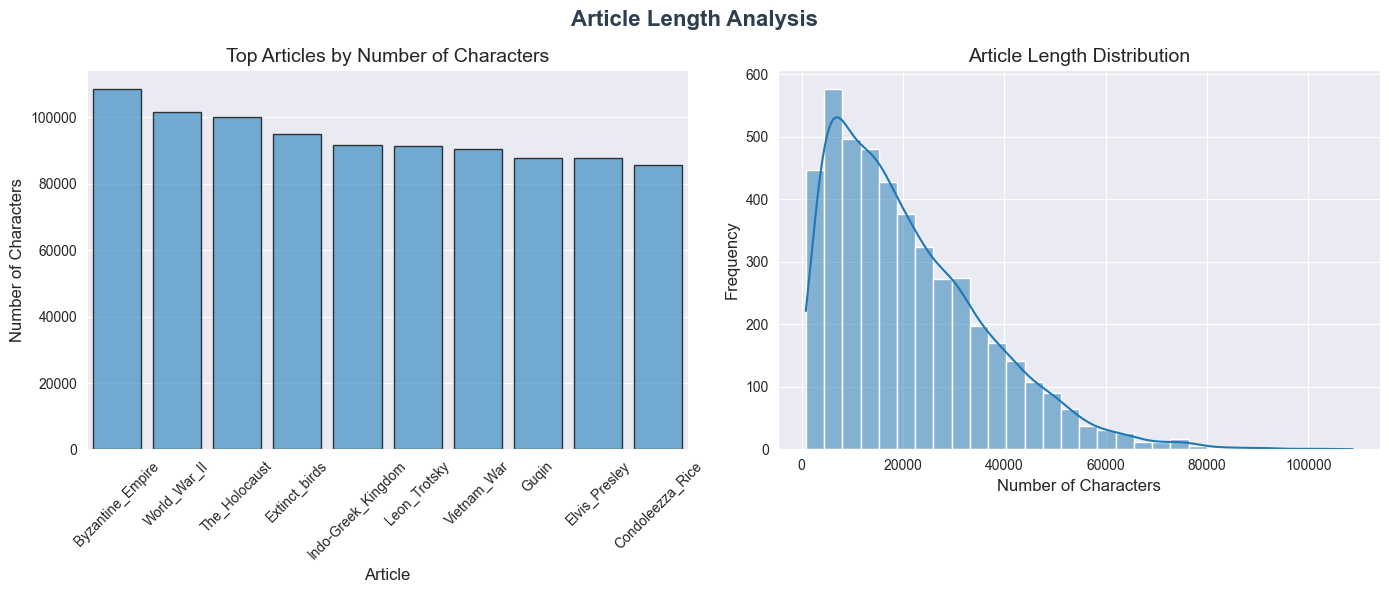

In [41]:
plot_article_length(article_df)

**Comment:** The top 10 articles with the highest letter count are dominated by historical events, likely because these events are long, well-documented, and contain a lot of information. In addition to historical events, three of the articles are biographical, indicating that articles about people can also have a high letter count which could be due to the detailed nature of their life histories leading to long articles. Most articles range between 8'000 and 30'000 characters, with a slight right skew due to a few very long articles, indicating considerable variation in article lengths.


### Semantic distance


We can compute basic semantic distance on articles simply by creating embeddings for the titles of the articles.

#### Computing the Embeddings :

First, let's compute the embeddings. We can follow a HuggingFace tutorial on generating text embeddings. This tutorial is found [here](https://huggingface.co/blog/getting-started-with-embeddings). For each title, we will generate an embedding, and store it in our dataframe.

In [ ]:
import requests

In [1]:
## Code to get the embeddings
# Extract all names
article_names = article_df['article']
article_names

# https://huggingface.co/blog/getting-started-with-embeddings
model_id = "sentence-transformers/all-MiniLM-L6-v2"
hf_token = "INSERT TOKEN HERE"


api_url = f"https://api-inference.huggingface.co/pipeline/feature-extraction/{model_id}"
headers = {"Authorization": f"Bearer {hf_token}"}

def query(texts):
    response = requests.post(api_url, headers=headers, json={"inputs": texts, "options":{"wait_for_model":True}})
    return response.json()

article_names_list = article_names.tolist()
article_names_list = [name.replace("_", " ") for name in article_names_list]


# Call the API to create the embeddings
output = query(article_names_list)

# Store the embeddings in the df
article_df['embeddings'] = output

# See the dimensionality of our embeddings
print(f'Dimensionality of Embeddings: {len(article_df['embeddings'][0])}')


### Analyzing the Embeddings

There are lots of tools to visualize and analyze embeddings. In order to extract meaningful representations, a common tactic is to reduce the dimensionality of the embeddings. The two main tools for this are PCA and T-SNE.
See [here](https://distill.pub/2016/misread-tsne/) for a great overview on T-SNE.
We can use both of these via scikit-learn. For now, we just want to get a feel for the data. Let's use tensorflow's Embedding Projector tool. This tool can be hosted locally or used in a browser.

#### Embedding Projector

Embedding Projector is a useful tool made by TF to look at word embedding spaces. Let's save our data so it can be opened there.

https://projector.tensorflow.org/

Note that the embedding projector can also be used locally.

### Exporting Metadata and Embeddings for Embedding Projector

In order to use Embedding Projector, we need to export the embeddings and metadata in tsv format. We want to also explore how well title embeddings capture semantic distance between categories, so we will include category information in our metadata.

In [ ]:
# Separate embeddings as a new DataFrame
embeddings_df = pd.DataFrame(article_df['embeddings'].tolist())

# Save embeddings to TSV
embeddings_df.to_csv('Data/embeddings/embeddings.tsv', sep='\t', header=False, index=False)

The number of categories is different per article, as is the number of sub-categories per category listing.

In [ ]:
max_category_length = 0
max_num_categories= 0
for category in articles['category']:
    if category is None:
        continue
    if len(category) > max_num_categories:
        max_num_categories = len(category)
    for c in category:
        split_at_period = c.split('.')
        if len(split_at_period) > max_category_length:
            max_category_length = len(split_at_period)

print(max_category_length)
print(max_num_categories)

In [ ]:
# Expand categories into multiple subcategory levels

# Prepare a DataFrame for metadata
metadata_df = articles[['article']].copy()

# Parse category information into separate columns
category_columns = [f'category_{j+1}_level_{i+1}' for j in range(max_num_categories) for i in range(max_category_length)]

for i in range(max_num_categories):
    for j in range(max_category_length):
        metadata_df[f'category_{i+1}_level{j+1}'] = articles['category'].apply(
            lambda x: x[i].split('.')[j] if x is not None and i < len(x) and j < len(x[i].split('.')) else None
        )

# We can drop the "level1" category, as it is always the string 'subject'
metadata_df = metadata_df.drop(columns=['category_1_level1', 'category_2_level1'], axis=1)

# # Save metadata to TSV
metadata_df.to_csv('Data/embeddings/metadata.tsv', sep='\t', header=True, index=False)

### TF's Embedding Projector

After saving our embeddings and their required metadata according to EmbeddingProjector's specifications, we can load the data into the tool. For now, let's use T-SNE in order to group the data. Here is what the data looks like after 1000 iterations of T-SNE:

![Default projections](Figures/default_1000_tsne.png)

But . . . does it even work? Well, let's do a gut check. What is that clump of titles at the top?

![Tropical Storms](Figures/tropical_storms.png)

Interesting! It seems like tropical storms are on a level of their own! That is, they share semantic meaning with each other but not other titles.Let's look at some common according to our statistics. For example, what is close to the United States?

![US TSNE](Figures/UnitedStates_TSNE.png)

We can also see what is close to the `United_States` title in the original, unprojected space. Cosine and Euclidean distance are both easily implementable in python, and already exist in multiple packages like scikit-learn.

![US Nearest](Figures/US_Nearest.png)

This Euclidean/Cosine distance will serve as our metric for semantic distance.

#### Categories in Embedding Space

After projecting using T-SNE, we can see how well the title embeddings align with categories. Here is the embedding projector, with each sub-category assigned its own color.

![Embeddings By Subject](Figures/embeddings_subject.png)

Looks quite nice, and is a good gut-check to see if categories align with title embeddings. In the above plot, for example, green is "People," orange is "History," pink is "Science," and bright blue is "Countries." There are 15 total primary categories, all represented above.

/Users/oscargoudet/Desktop/ada-2024-project-adaholiks/src/scripts/article_processing.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_column_embeddings.rename(columns={'array': 'embeddings'}, inplace=True)
/Users/oscargoudet/.virtualenvs/ada-2024-project-adaholiks/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/oscargoudet/.virtualenvs/ada-2024-project-adaholiks/lib/python3.9/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/oscargoudet/.virtualenvs/ada-2024-project-adaholiks/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._

Summary statistics for average cosine distance:
count    4587.000000
mean        0.714854
std         0.086560
min         0.194418
25%         0.658448
50%         0.717768
75%         0.777854
max         0.971088
Name: average_cosine_distance, dtype: float64


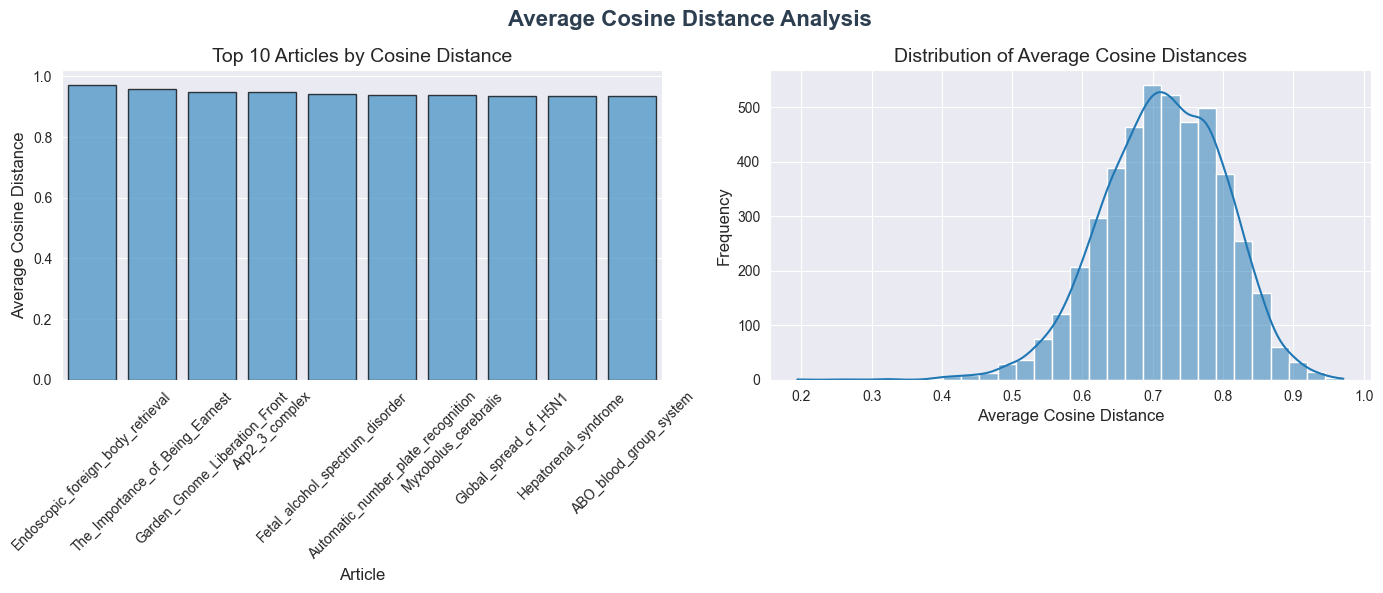

In [43]:
embeddings = pd.read_csv('Data/embeddings/embeddings.tsv', sep='\t', header=None)
article_df = add_average_cosine_distance(article_df, embeddings)
plot_average_cosine_distance(article_df)

Add an explanation of what we see here

### Vocabulary richness

Another attribute that we think could be interesting is vocabulary richness. This could potentially be a good indicator of the quality of an article.

Summary statistics for vocabulary richness:
count    4604.000000
mean        0.369981
std         0.094584
min         0.121154
25%         0.299972
50%         0.353456
75%         0.426332
max         0.732673
Name: vocabulary_richness, dtype: float64


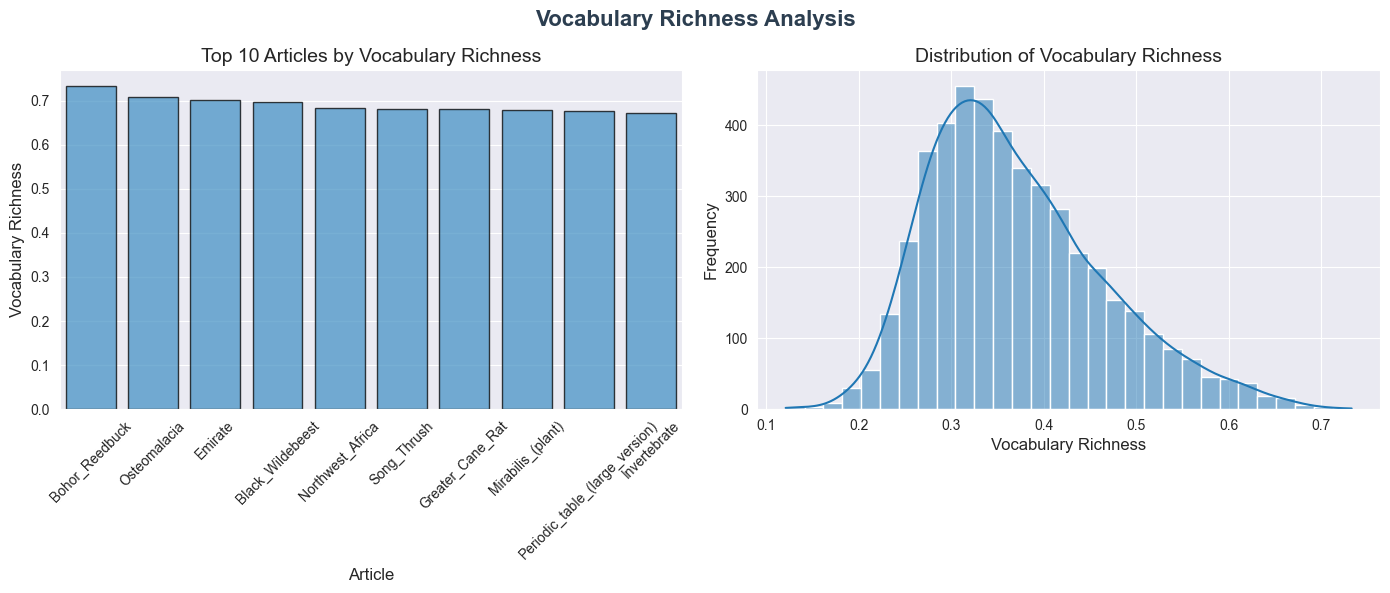

In [44]:
article_df = add_vocabulary_richness(article_df)
plot_vocabulary_richness(article_df)

In [45]:
article_df.to_feather('Data/dataframes/article_df_features.feather')

**END OF PREPROCESSING & exploratory data analysis**

# Part 2 : graph theory based top articles

**Comment:** In this analysis, we have divided the count by the total number of shortest paths for each source-target pair. This normalization helps us measure the true importance of each article in the network. Without normalization, an article that appears in every shortest path for a specific source-target pair might seem highly important, even if it doesn’t play a critical role across the entire network. By normalizing, we avoid overemphasizing articles that are only crucial within specific source-target pairs and ensure that the count more accurately reflects an article’s overall significance in the network.

$$
\text{Article k's Importance in (i ; j)} = \frac{A_{k}^{(i,j)}}{P^{(i,j)}}
$$

where:

$$
\begin{aligned}
A_{k}^{(i,j)} &= \text{Number of times article } k \text{ appears in shortest paths between source } i \text{ and target } j, \\
P^{(i,j)} &= \text{Total number of shortest paths between } i \text{ and } j.
\end{aligned}
$$



In [47]:

paths_finished['finished'] = True
paths_finished['failure_reason'] = None

paths_finished['start_article'] = paths_finished['path'].apply(lambda x: x.split(';')[0])
paths_finished['target_article'] = paths_finished['path'].apply(lambda x: x.split(';')[-1])


paths_unfinished['finished'] = False

paths_unfinished.rename(columns={'type': 'failure_reason', 'target' : 'target_article'}, inplace=True)

paths_unfinished['start_article'] = paths_unfinished['path'].apply(lambda x: x.split(';')[0])

paths = pd.concat([paths_finished, paths_unfinished])

finished_paths = paths[paths['finished'] == True]

unique_pairs = finished_paths[['start_article', 'target_article']].drop_duplicates()

pair_counts = finished_paths.groupby(['start_article', 'target_article']).size().reset_index(name='count')

#pair_counts

NameError: name 'paths_finished' is not defined

**Comment:** We also decided to concentrate our analysis on source-target pairs that are actually used in the game. By focusing only on these pairs, we generate a final list of articles that are theoretically advantageous for all possible gameplay scenarios. This approach prevents the inclusion of articles that may appear to be effective in connecting pairs not relevant to the game, which could otherwise skew the analysis.

In [ ]:
from collections import defaultdict

node_counts = defaultdict(int)

errors = 0

all_nb_of_shortest_paths = []

for _, row in pair_counts.iterrows():
    source = row['start_article']
    target = row['target_article']

    try:

        all_paths = list(nx.all_shortest_paths(G, source=source, target=target))

        nb_of_shortest_paths = len(all_paths)

        all_nb_of_shortest_paths.append(nb_of_shortest_paths)
        
        for path in all_paths:
            for node in path:
                if node != source and node != target:
                    node_counts[node] += 1/nb_of_shortest_paths

    except nx.NetworkXNoPath:
        # Skip this source-target pair if no path exists
        errors +=1


node_counts_df = pd.DataFrame(node_counts.items(), columns=['Node', 'ShortestPathCount'])

### Results

In [ ]:
# Sort by the 'ShortestPathCount' column in ascending order
node_counts_df = node_counts_df.sort_values(by='ShortestPathCount', ascending=False)
node_counts_df.head(20)

,Node,ShortestPathCount
27,United_States,2778.997827
124,United_Kingdom,1128.250118
77,Europe,809.943234
79,England,746.721314
174,Africa,716.774062
2,Germany,614.765519
92,World_War_II,534.374375
230,Japan,526.817727
143,Earth,480.186276
1,France,417.042087


**Comment:** Here, we display the first 20 articles identified as most important across the network. These articles are ranked based on their normalized shortest path count, highlighting those that play a critical role in connecting various parts of the network. We can notice that topics related to influential countries (like the United States and the United Kingdom), broad regions (such as Europe and Africa), and significant historical events (like World War II) are among the highest-ranked. This suggests that geopolitical, regional, and historical themes are central to the network's structure, serving as key connectors across diverse topics.

In [ ]:
node_counts_df['ShortestPathCount'].describe()

count    3735.000000
mean       13.928782
std        63.764178
min         0.003125
25%         0.506233
50%         2.513890
75%         9.294983
max      2778.997827
Name: ShortestPathCount, dtype: float64

**Comment:** 
- *Count :* Here, we see that 3'735 out of 4'604 articles are active nodes in the games network, representing about 81% of the total. This suggests that the majority of articles contribute to the games network's connectivity, while the remaining 19% may be more isolated or peripheral.
- *Mean :* The mean suggests most articles are not very important based on our metric. The quantiles support this, with the 25th and 50th percentiles showing that most articles appear in only a few shortest paths. A small number of articles are highly central, indicating a long-tailed distribution where a few nodes dominate the network.

# Part 4 : Analysis of the results found and correlation with attributes

In [1]:
# temporary not to have to rerun eveything
import pandas as pd
import pyarrow.feather as feather
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import requests
from sklearn.manifold import TSNE

from src.load_data import *
from src.graph_data import *
from src.utils import *
from src.scripts import *

/Users/oscargoudet/.virtualenvs/ada-2024-project-adaholiks/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


['/Users/oscargoudet/Desktop/ada-2024-project-adaholiks', '/Applications/PyCharm.app/Contents/plugins/python-ce/helpers/pydev', '/Applications/PyCharm.app/Contents/plugins/python/helpers-pro/jupyter_debug', '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python39.zip', '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9', '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/lib-dynload', '', '/Users/oscargoudet/.virtualenvs/ada-2024-project-adaholiks/lib/python3.9/site-packages', '/Users/oscargoudet/Desktop', '/Users/oscargoudet/Desktop']
---- WARNING: The following articles have a problem: ----
Badugi has no links (out-edges) listed.
Color_Graphics_Adapter has no links (out-edges) listed.
Directdebit has no category listed.
Directdebit has no links (out-edges) listed.
Donation has no category listed.
Donation has no links (out-edges) listed.
Dougl

In [2]:
# new import list (add all needed imports here not)
import os
import pyarrow.feather as feather
from src.scripts.load_data import load_data
from src.scripts.convert_into_df import paths_to_df, articles_to_df
from src.scripts.path_processing import filter_paths
from src.scripts.backup_dfs import backup_dataframes
from src.utils.helpers import plot_path_length_distributions, plot_by_distance, plot_duration_histogram, plot_styled_bar_chart

Here we will study the correlation between our article attributes and the ranking metrics that we came up with. First we load our article dataframe and merge the different scores computed earlier to it. So we now have a dataframe the name of the article, its features and its score (quality/utility/speed).

In [17]:
# load article dataframe aswell as score dataframes

article_df = feather.read_feather('Data/dataframes/article_df_features.feather')

quality_scores_clicks_df = feather.read_feather('Data/dataframes/quality_scores_clicks.feather')
utility_scores_clicks_df = feather.read_feather('Data/dataframes/utility_scores_clicks.feather')
scores_speed_df = feather.read_feather('Data/dataframes/speed_scores.feather')

top_4_scores_df = feather.read_feather('Data/dataframes/top_4_scores_df.feather')
top_4_click_scores_df = feather.read_feather('Data/dataframes/top_4_click_scores_df.feather')
top_4_speed_scores_df = feather.read_feather('Data/dataframes/top_4_speed_scores_df.feather')

In [18]:
article_df

,article,category,linkTarget,distances,plain_text,incoming_links,num_hyperlinks,num_characters,hyperlink_density,embeddings,average_cosine_distance,vocabulary_richness
0,Áedán_mac_Gabráin,[subject.History.British_History.British_Histo...,"[Bede, Columba, Dál_Riata, Great_Britain, Irel...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nÁedán mac Gabráin\n\n2007 Sch...,0,11,11612,0.000947,"[-0.1292391121387481, 0.0236219353973865, -0.0...",0.785123,0.318346
1,Åland,"[subject.Countries, subject.Geography.European...","[20th_century, Baltic_Sea, Crimean_War, Curren...","{'10th_century': 2.0, '11th_century': 2.0, '12...",#copyright\n\nÅland\n\n2007 Schools Wikiped...,0,19,17238,0.001102,"[-0.0536498501896858, -0.018478475511074, -0.0...",0.790986,0.376456
2,Édouard_Manet,[subject.People.Artists],"[Absinthe, Beer, Claude_Monet, Diego_Velázquez...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nÉdouard Manet\n\n2007 Schools...,0,20,18996,0.001053,"[-0.0170925538986921, 0.0835338979959487, -0.0...",0.758071,0.368298
3,Éire,"[subject.Countries, subject.Geography.European...","[Canada, English_language, George_VI_of_the_Un...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nÉire\n\n2007 Schools Wikipedi...,0,8,13083,0.000611,"[0.0483395084738731, 0.0465945191681385, 0.052...",0.697083,0.329540
4,Óengus_I_of_the_Picts,[subject.History.British_History.British_Histo...,"[Dál_Riata, Durham, England, Great_Britain, Ir...","{'10th_century': 2.0, '11th_century': 2.0, '12...",#copyright\n\nÓengus I of the Picts\n\n2007...,0,10,12944,0.000773,"[-0.076491080224514, 0.1048120632767677, -0.04...",0.823469,0.333808
...,...,...,...,...,...,...,...,...,...,...,...,...
4599,Zionism,"[subject.People.Political_People, subject.Reli...","[18th_century, 19th_century, Adolf_Hitler, Alb...","{'10th_century': 2.0, '11th_century': 2.0, '12...",#copyright\n\nZionism\n\n2007 Schools Wikip...,25,74,62086,0.001192,"[-0.0160204768180847, 0.0894060954451561, -0.0...",0.692210,0.247640
4600,Zirconium,[subject.Science.Chemistry.Chemical_elements],"[Aluminium, Arabic_language, Australia, Bicycl...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nZirconium\n\n2007 Schools Wik...,15,42,13253,0.003169,"[-0.1054912209510803, 0.0234880838543176, -0.1...",0.719828,0.458779
4601,Zoroaster,[subject.People.Religious_figures_and_leaders],"[18th_century, 9th_century, Afghanistan, Age_o...","{'10th_century': 2.0, '11th_century': 2.0, '12...",#copyright\n\nZoroaster\n\n2007 Schools Wik...,9,28,19726,0.001419,"[-0.0665727406740188, 0.1222779899835586, -0.0...",0.783683,0.386653
4602,Zuid-Gelders,"[subject.Geography.European_Geography, subject...","[Brabantian, Dutch_language, East_Flemish, Hol...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nZuid-Gelders\n\n2007 Schools ...,5,5,2341,0.002136,"[-0.173138827085495, 0.0952244028449058, 0.006...",0.833498,0.488372


In [19]:
merged_quality_df = article_df.merge(quality_scores_clicks_df, on='article', how='inner')
merged_utility_df = article_df.merge(utility_scores_clicks_df, on='article', how='inner')
merged_speed_df = article_df.merge(scores_speed_df, on='article', how='inner')

## Evaluation of the quality scores

We will first study the correlation between our article attributes and the quality score it got.

In [23]:
from src.scripts.correlation_processing import  *
from src.utils.helpers import *

In [21]:
# drop all columns that are not attributes or scores from merged_df
merged_quality_df.drop(columns=['plain_text','category','linkTarget','distances','embeddings','n_appearances'], inplace=True)

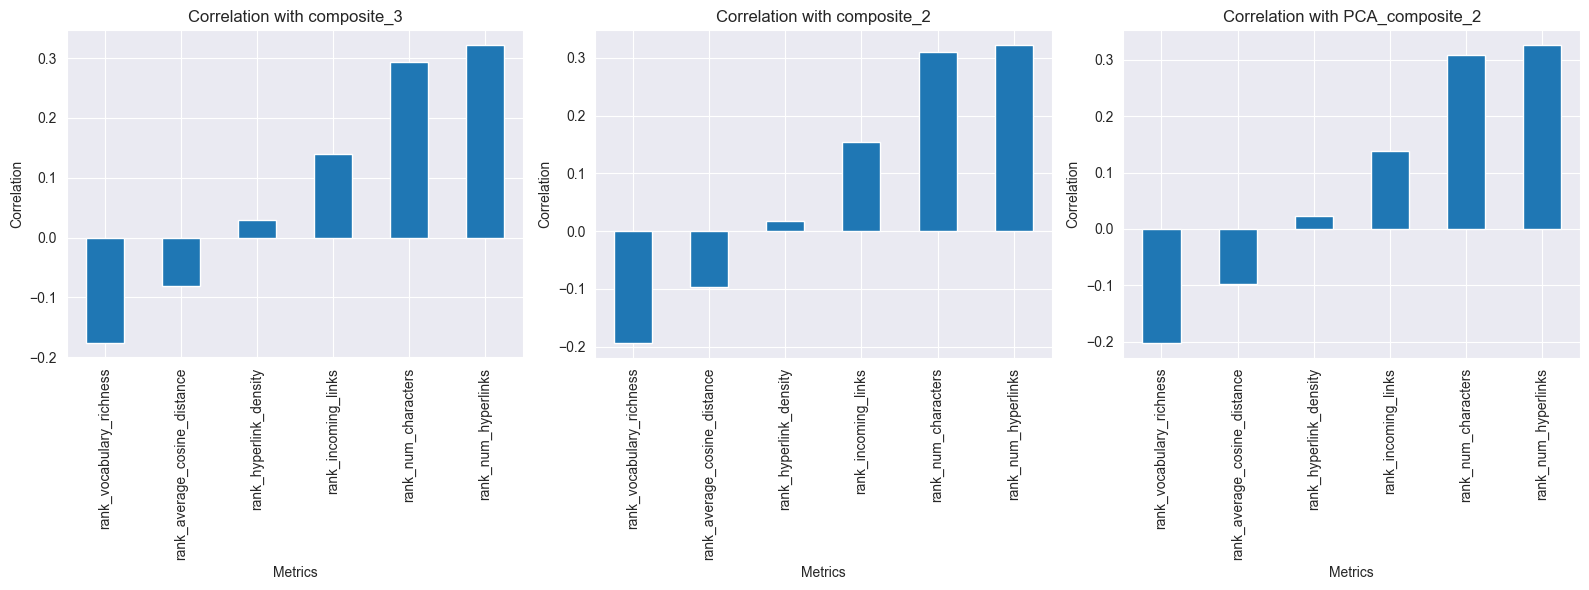

In [7]:
attributes = ['incoming_links', 'num_hyperlinks', 'num_characters', 'hyperlink_density', 'average_cosine_distance', 'vocabulary_richness']
composites = ['composite_3', 'composite_2', 'PCA_composite_2']

correlations = rank_attributes(merged_quality_df, attributes, composites)
plot_correlations(correlations)

## A Machine Learning Approach To Extracting Next Articles

